In [3]:
import pingouin as pg
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [4]:
def holm_bonferroni(dataframe, p_col, alpha):
    """
    Perform the Holm-Bonferroni correction for multiple comparisons.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame containing p-values.
    p_col (str): Name of the column containing p-values.
    alpha (float): Significance level for controlling FWER.

    Returns:
    list: Indices of hypotheses that are retained
    """
    # Extract and sort p-values
    p_values = dataframe[p_col].sort_values().reset_index()
    p_values.columns = ['original_index', 'p_value']

    m = len(p_values)
    retained_indices = []

    for k in range(1, m + 1):
        threshold = alpha / (m + 1 - k)
        if p_values.loc[k - 1, 'p_value'] <= threshold:
            retained_indices.append(p_values.loc[k - 1, 'original_index'])
        else:
            break

    return retained_indices


### Horizon-layer combinations

In [5]:
# Load the dataframes
individual_predictors_replace_surprisal_devarda = pd.read_csv("results/ols_aligned_ias_horizon_layer_against_surprisal.csv")
individual_predictors_replace_surprisal_ns = pd.read_csv("results/ols_ns_ias_horizon_layer_against_surprisal.csv")

# Load the dataframes
individual_predictors_devarda = pd.read_csv("results_final/ols_aligned_ias_cosine_std_horizon_layer_against_control.csv")
individual_predictors_ns = pd.read_csv("results_final/ols_ns_ias_cosine_std_horizon_layer_against_control.csv")

# Fix the distance metric
distance_metric = "cosine_std"
individual_predictors_replace_surprisal_devarda = individual_predictors_replace_surprisal_devarda[individual_predictors_replace_surprisal_devarda["dist_metric"] == distance_metric]
individual_predictors_replace_surprisal_ns = individual_predictors_replace_surprisal_ns[individual_predictors_replace_surprisal_ns["dist_metric"] == distance_metric]
individual_predictors_devarda = individual_predictors_devarda[individual_predictors_devarda["dist_metric"] == distance_metric]
individual_predictors_ns = individual_predictors_ns[individual_predictors_ns["dist_metric"] == distance_metric]


In [11]:
# Perform the Holm-Bonferroni correction

alpha = 0.05

individual_predictors_replace_surprisal_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(individual_predictors_replace_surprisal_devarda, 'anova_p', alpha)
individual_predictors_replace_surprisal_devarda.loc[retained_indices_aligned, 'significant'] = True

individual_predictors_replace_surprisal_ns['significant'] = False
retained_indices_ns = holm_bonferroni(individual_predictors_replace_surprisal_ns, 'anova_p', alpha)
individual_predictors_replace_surprisal_ns.loc[retained_indices_ns, 'significant'] = True

individual_predictors_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(individual_predictors_devarda, 'anova_p', alpha)
individual_predictors_devarda.loc[retained_indices_aligned, 'significant'] = True

individual_predictors_ns['significant'] = False
retained_indices_ns = holm_bonferroni(individual_predictors_ns, 'anova_p', alpha)
individual_predictors_ns.loc[retained_indices_ns, 'significant'] = True


In [12]:
# Merge the two dataframes
individual_predictors_replace_surprisal_devarda["corpus"] = "DeVarda"
individual_predictors_replace_surprisal_ns["corpus"] = "Natural Stories"
individual_predictors_replace_surprisal = pd.concat([individual_predictors_replace_surprisal_devarda, individual_predictors_replace_surprisal_ns])

# Merge the two dataframes
individual_predictors_devarda["corpus"] = "DeVarda"
individual_predictors_ns["corpus"] = "Natural Stories"
individual_predictors = pd.concat([individual_predictors_devarda, individual_predictors_ns])

individual_predictors_replace_surprisal['baseline'] = 'Surprisal'
individual_predictors['baseline'] = 'Control'

individual_predictors_all = pd.concat([individual_predictors_replace_surprisal, individual_predictors])


rename_model_dict = {
    'gpt2_small': 'GPT-2 Small',
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2_xl': 'GPT-2 XL'
}
rename_aggregation_dict = {
    'mean': r'$d_{mean}$',
    'max': r'$d_{max}$',
    'min': r'$d_{min}$'
}

y_labels = {
    'rating_mean': 'Predictability',
    'cloze_p_smoothed': 'Cloze probability',
    'cloze_s': 'Cloze surprisal',
    # 'entropy': 'Cloze entropy',
    # 'rating_s': 'Log predictability',
    # 'rating_sd': 'Predictability SD',
    'RTfirstfix': 'First fixation RT',
    'RTfirstpass': 'First pass RT',
    'RTrightbound': 'Right-bounded RT',
    'RTgopast': 'Go-past RT',
    'self_paced_reading_time': 'Self-paced RT \n(Aligned)',
    'meanItemRT': 'Self-paced RT\n(Natural Stories)',
    'ELAN': 'ELAN',
    'LAN': 'LAN',
    'PNP': 'PNP',
    'EPNP': 'EPNP',
    'P600': 'P600',
    'N400': 'N400',
    # 'sdItemRT': 'Self-paced RT SD\n(Natural Stories)',
}

# Add human-readable names to the dataframes
individual_predictors_all['aggregation_name'] = individual_predictors_all['aggregation'].map(rename_aggregation_dict)
individual_predictors_all['model'] = individual_predictors_all['model'].map(rename_model_dict)

# Add layer depth to the dataframe
layer_depth = []
for _, row in individual_predictors_all.iterrows():
    if row.metric == 'Surprisal' or row.layer == 'All':
        layer_depth.append(None)
        continue
    if row.model == 'GPT-2 Small':
        layer_depth.append(str(int(round(100 * int(row.layer) / 12))))
    elif row.model == 'GPT-2 Medium':
        layer_depth.append(str(int(round(100 * int(row.layer) / 24))))
    elif row.model == 'GPT-2 Large':
        layer_depth.append(str(int(round(100 * int(row.layer) / 36))))
    elif row.model == 'GPT-2 XL':
        layer_depth.append(str(int(round(100 * int(row.layer) / 48))))
    else:
        layer_depth.append(None)
individual_predictors_all['layer_depth'] = layer_depth


In [22]:
individual_predictors_all.fold

3        full
7        full
11       full
15       full
19       full
         ... 
11435       9
11436       9
11437       9
11438       9
11439       9
Name: fold, Length: 112320, dtype: object

#### Predictability

<>:88: SyntaxWarning: invalid escape sequence '\D'
<>:88: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_96341/1671647199.py:88: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(1, 0.46, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':20}, rotation=270)


<Figure size 2200x1000 with 0 Axes>

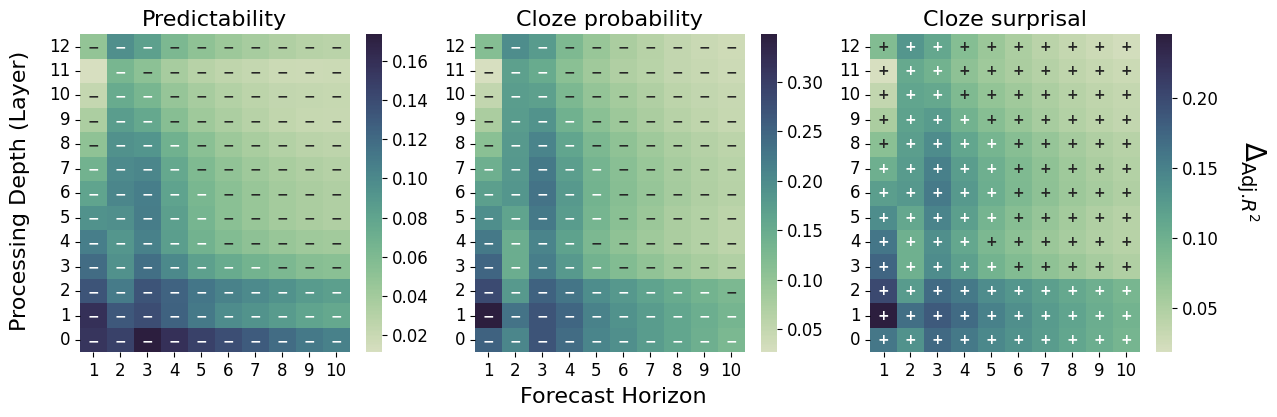

<Figure size 2200x1000 with 0 Axes>

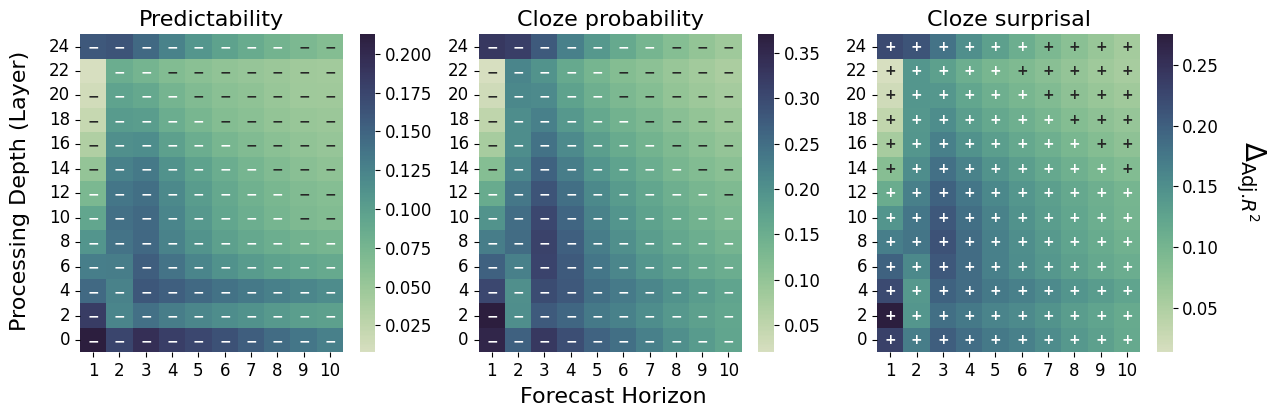

<Figure size 2200x1000 with 0 Axes>

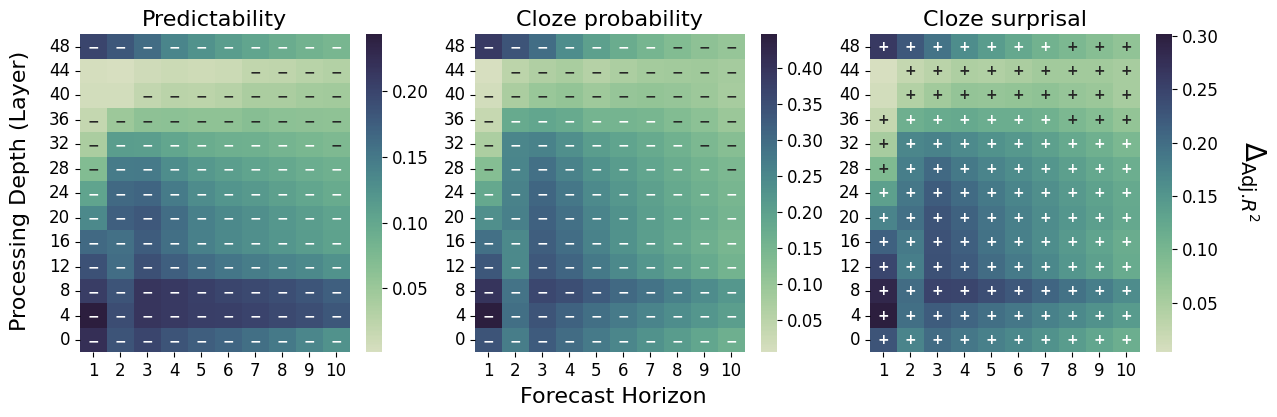

<Figure size 2200x1000 with 0 Axes>

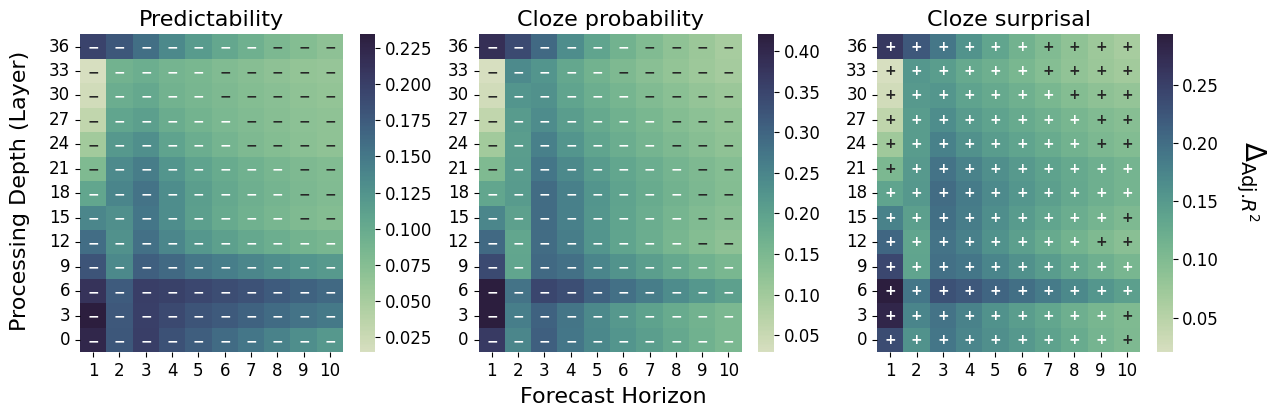

In [23]:
for model_size in ['Small', 'Medium', 'XL', 'Large']:
    plt.figure(figsize=(22, 10))

    data_to_plot = individual_predictors_all[
        (individual_predictors_all['model'] == f'GPT-2 {model_size}') &
        (individual_predictors_all['y'].isin(['rating_mean', 'cloze_p_smoothed', 'cloze_s'])) &
        (individual_predictors_all['baseline'] == 'Control') & 
        (individual_predictors_all['fold'] == 'full')
    ]

    # min_delta_rsq_adj_control = data_to_plot[(data_to_plot['baseline'] == 'Control')]['delta_rsquared_adj'].min()
    # max_delta_rsq_adj_control = data_to_plot[(data_to_plot['baseline'] == 'Control')]['delta_rsquared_adj'].max()
    # min_delta_rsq_adj_control_surprisal = data_to_plot[(data_to_plot['baseline'] == 'Control + Surprisal')]['delta_rsquared_adj'].min()
    # max_delta_rsq_adj_control_surprisal = data_to_plot[(data_to_plot['baseline'] == 'Control + Surprisal')]['delta_rsquared_adj'].max()

    # order entries such that baseline control comes before control + surprisal
    data_to_plot = data_to_plot.sort_values(by=['baseline', 'y'])

    g = sns.FacetGrid(data_to_plot, col='y', height=4, 
                    #   row='baseline', 
                      margin_titles=False, sharey=False, col_order=['rating_mean', 'cloze_p_smoothed', 'cloze_s'])

    
    def plot_subplot(data, **kwargs):
        matrix = np.zeros((len(data.layer.unique()), len(data.horizon.unique())))
        labels_matrix = np.zeros_like(matrix).tolist()
        for j, layer in enumerate(data.layer.unique()[::-1]):
            for k, horizon in enumerate(data.horizon.unique()):
                tmp_df = data[
                    (data.layer == layer) &
                    (data.horizon == horizon)
                ]

                matrix[j, k] = tmp_df["delta_rsquared_adj"].item()
                if tmp_df["significant"].item():
                    labels_matrix[j][k] = "$\\boldsymbol{+}$" if tmp_df["ias_coef"].item() > 0 else "$\\boldsymbol{-}$"
                else:
                    labels_matrix[j][k] = ""

        ax = sns.heatmap(
            matrix, 
            ax=plt.gca(), 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            vmin=data.delta_rsquared_adj.min(), #min_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else min_delta_rsq_adj_control_surprisal,
            vmax=data.delta_rsquared_adj.max(),  #max_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else max_delta_rsq_adj_control_surprisal,
            annot = labels_matrix,
            annot_kws={"size": 10},
            fmt="s",
            xticklabels=data.horizon.unique(),
            yticklabels=data.layer.unique()[::-1],
            cbar=True,
            #size of colorbar FONT
            # cbar=True if data.y.unique()[0] == 'rating_mean' else False,
            # square=True,
        )

        # set title
        if data.baseline.unique()[0] == 'Control':
            plt.title(f'{y_labels[data.y.unique()[0]]}', fontsize=16)
        else:
            plt.title("")


        # change font size of x and y ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12, rotation=0)

        ax.figure.axes[-1].tick_params(labelsize=12)

        # # change font size of colorbar
        # cbar = plt.colorbar()
        # cbar.ax.tick_params(labelsize=12)

    # Map the function to each subplot
    g.map_dataframe(plot_subplot)

    # Adjust labels and legend
    g.set_axis_labels('', '')

    # set title
    # for ax, y in zip(g.axes.flat, y_labels.values()):
    #     ax.set_title(y)
        
    g.fig.text(0.405, -0.02, s='Forecast Horizon',fontdict={'fontsize':16})
    g.fig.text(-0.02, 0.17, s='Processing Depth (Layer)',fontdict={'fontsize':16}, rotation=90)
    # g.fig.text(1.03, 0.50, s='$\Delta_{R^2}$',fontdict={'fontsize':16}, rotation=270)
    # g.fig.text(1.005, 0.06, s='Baseline = Control + Surprisal',fontdict={'fontsize':16}, rotation=270)
    g.fig.text(1, 0.46, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':20}, rotation=270)

    plt.tight_layout()

    # plt.savefig(f'figures/revision2/individual_predictors_over_control_for_predictability_{model_size.lower()}.pdf', bbox_inches='tight')
    plt.show()


    

<>:88: SyntaxWarning: invalid escape sequence '\D'
<>:88: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_96341/1344165591.py:88: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(1, 0.47, s='$\Delta_{\\mathcal{L}}$',fontdict={'fontsize':20}, rotation=270)


<Figure size 2200x1000 with 0 Axes>

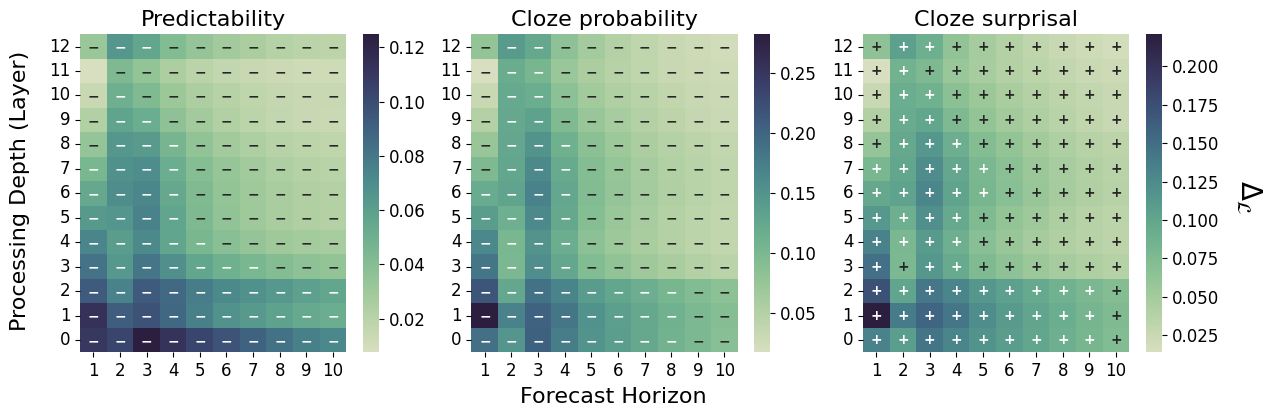

<Figure size 2200x1000 with 0 Axes>

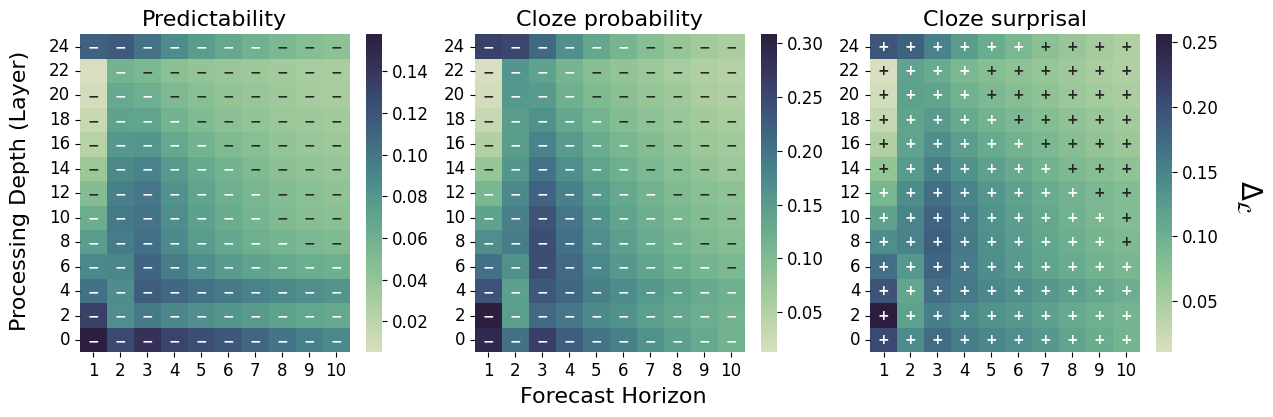

<Figure size 2200x1000 with 0 Axes>

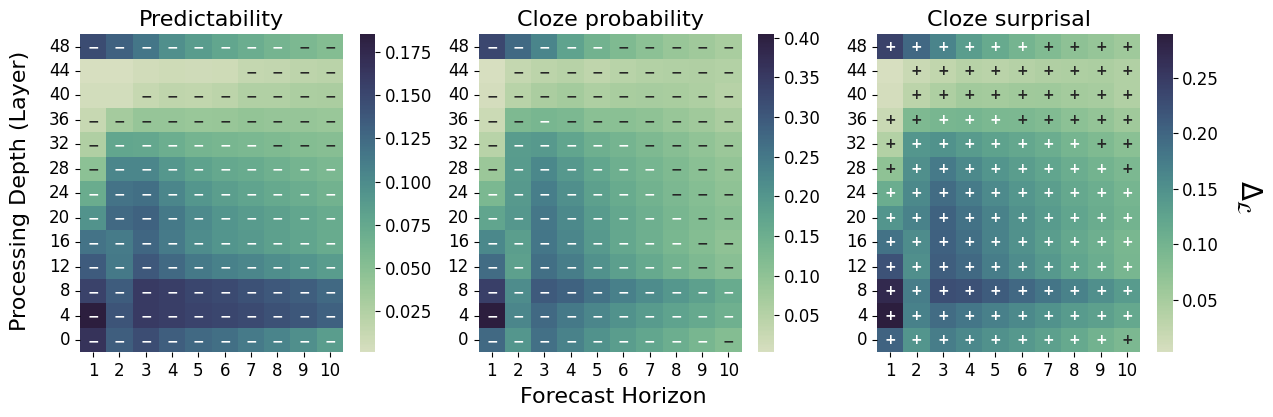

<Figure size 2200x1000 with 0 Axes>

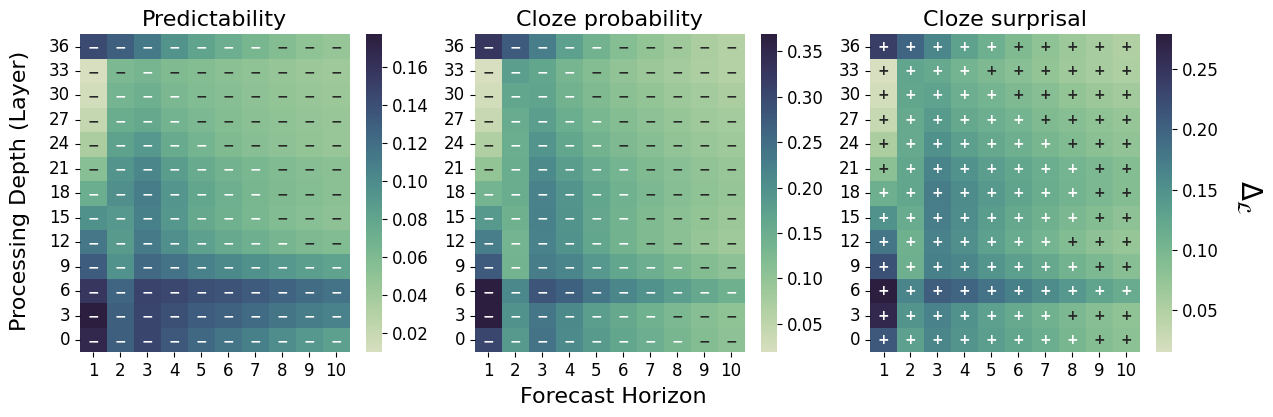

In [25]:
for model_size in ['Small', 'Medium', 'XL', 'Large']:
    plt.figure(figsize=(22, 10))

    data_to_plot = individual_predictors_all[
        (individual_predictors_all['model'] == f'GPT-2 {model_size}') &
        (individual_predictors_all['y'].isin(['rating_mean', 'cloze_p_smoothed', 'cloze_s'])) &
        (individual_predictors_all['baseline'] == 'Control') &
        (individual_predictors_all['fold'] == 'full')
    ]

    # min_delta_rsq_adj_control = data_to_plot[(data_to_plot['baseline'] == 'Control')]['delta_rsquared_adj'].min()
    # max_delta_rsq_adj_control = data_to_plot[(data_to_plot['baseline'] == 'Control')]['delta_rsquared_adj'].max()
    # min_delta_rsq_adj_control_surprisal = data_to_plot[(data_to_plot['baseline'] == 'Control + Surprisal')]['delta_rsquared_adj'].min()
    # max_delta_rsq_adj_control_surprisal = data_to_plot[(data_to_plot['baseline'] == 'Control + Surprisal')]['delta_rsquared_adj'].max()

    # order entries such that baseline control comes before control + surprisal
    data_to_plot = data_to_plot.sort_values(by=['baseline', 'y'])

    g = sns.FacetGrid(data_to_plot, col='y', height=4, 
                    #   row='baseline', 
                      margin_titles=False, sharey=False, col_order=['rating_mean', 'cloze_p_smoothed', 'cloze_s'])

    
    def plot_subplot(data, **kwargs):
        matrix = np.zeros((len(data.layer.unique()), len(data.horizon.unique())))
        labels_matrix = np.zeros_like(matrix).tolist()
        for j, layer in enumerate(data.layer.unique()[::-1]):
            for k, horizon in enumerate(data.horizon.unique()):
                tmp_df = data[
                    (data.layer == layer) &
                    (data.horizon == horizon)
                ]

                matrix[j, k] = tmp_df["delta_loglik"].item()
                if tmp_df["significant"].item():
                    labels_matrix[j][k] = "$\\boldsymbol{+}$" if tmp_df["ias_coef"].item() > 0 else "$\\boldsymbol{-}$"
                else:
                    labels_matrix[j][k] = ""

        ax = sns.heatmap(
            matrix, 
            ax=plt.gca(), 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            vmin=data.delta_loglik.min(), #min_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else min_delta_rsq_adj_control_surprisal,
            vmax=data.delta_loglik.max(),  #max_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else max_delta_rsq_adj_control_surprisal,
            annot = labels_matrix,
            annot_kws={"size": 10},
            fmt="s",
            xticklabels=data.horizon.unique(),
            yticklabels=data.layer.unique()[::-1],
            cbar=True,
            #size of colorbar FONT
            # cbar=True if data.y.unique()[0] == 'rating_mean' else False,
            # square=True,
        )

        # set title
        if data.baseline.unique()[0] == 'Control':
            plt.title(f'{y_labels[data.y.unique()[0]]}', fontsize=16)
        else:
            plt.title("")


        # change font size of x and y ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12, rotation=0)

        ax.figure.axes[-1].tick_params(labelsize=12)

        # # change font size of colorbar
        # cbar = plt.colorbar()
        # cbar.ax.tick_params(labelsize=12)

    # Map the function to each subplot
    g.map_dataframe(plot_subplot)

    # Adjust labels and legend
    g.set_axis_labels('', '')

    # set title
    # for ax, y in zip(g.axes.flat, y_labels.values()):
    #     ax.set_title(y)
        
    g.fig.text(0.405, -0.02, s='Forecast Horizon',fontdict={'fontsize':16})
    g.fig.text(-0.02, 0.17, s='Processing Depth (Layer)',fontdict={'fontsize':16}, rotation=90)
    # g.fig.text(1.03, 0.50, s='$\Delta_{R^2}$',fontdict={'fontsize':16}, rotation=270)
    # g.fig.text(1.005, 0.06, s='Baseline = Control + Surprisal',fontdict={'fontsize':16}, rotation=270)
    g.fig.text(1, 0.47, s='$\Delta_{\\mathcal{L}}$',fontdict={'fontsize':20}, rotation=270)

    plt.tight_layout()

    plt.savefig(f'figures/revision2/individual_predictors_over_control_for_predictability_{model_size.lower()}_loglik.pdf', bbox_inches='tight')
    plt.show()


    

#### Processing difficulty

<>:78: SyntaxWarning: invalid escape sequence '\D'
<>:78: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/1701043504.py:78: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(1.01, 0.47, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':26}, rotation=270)


<Figure size 2200x1400 with 0 Axes>

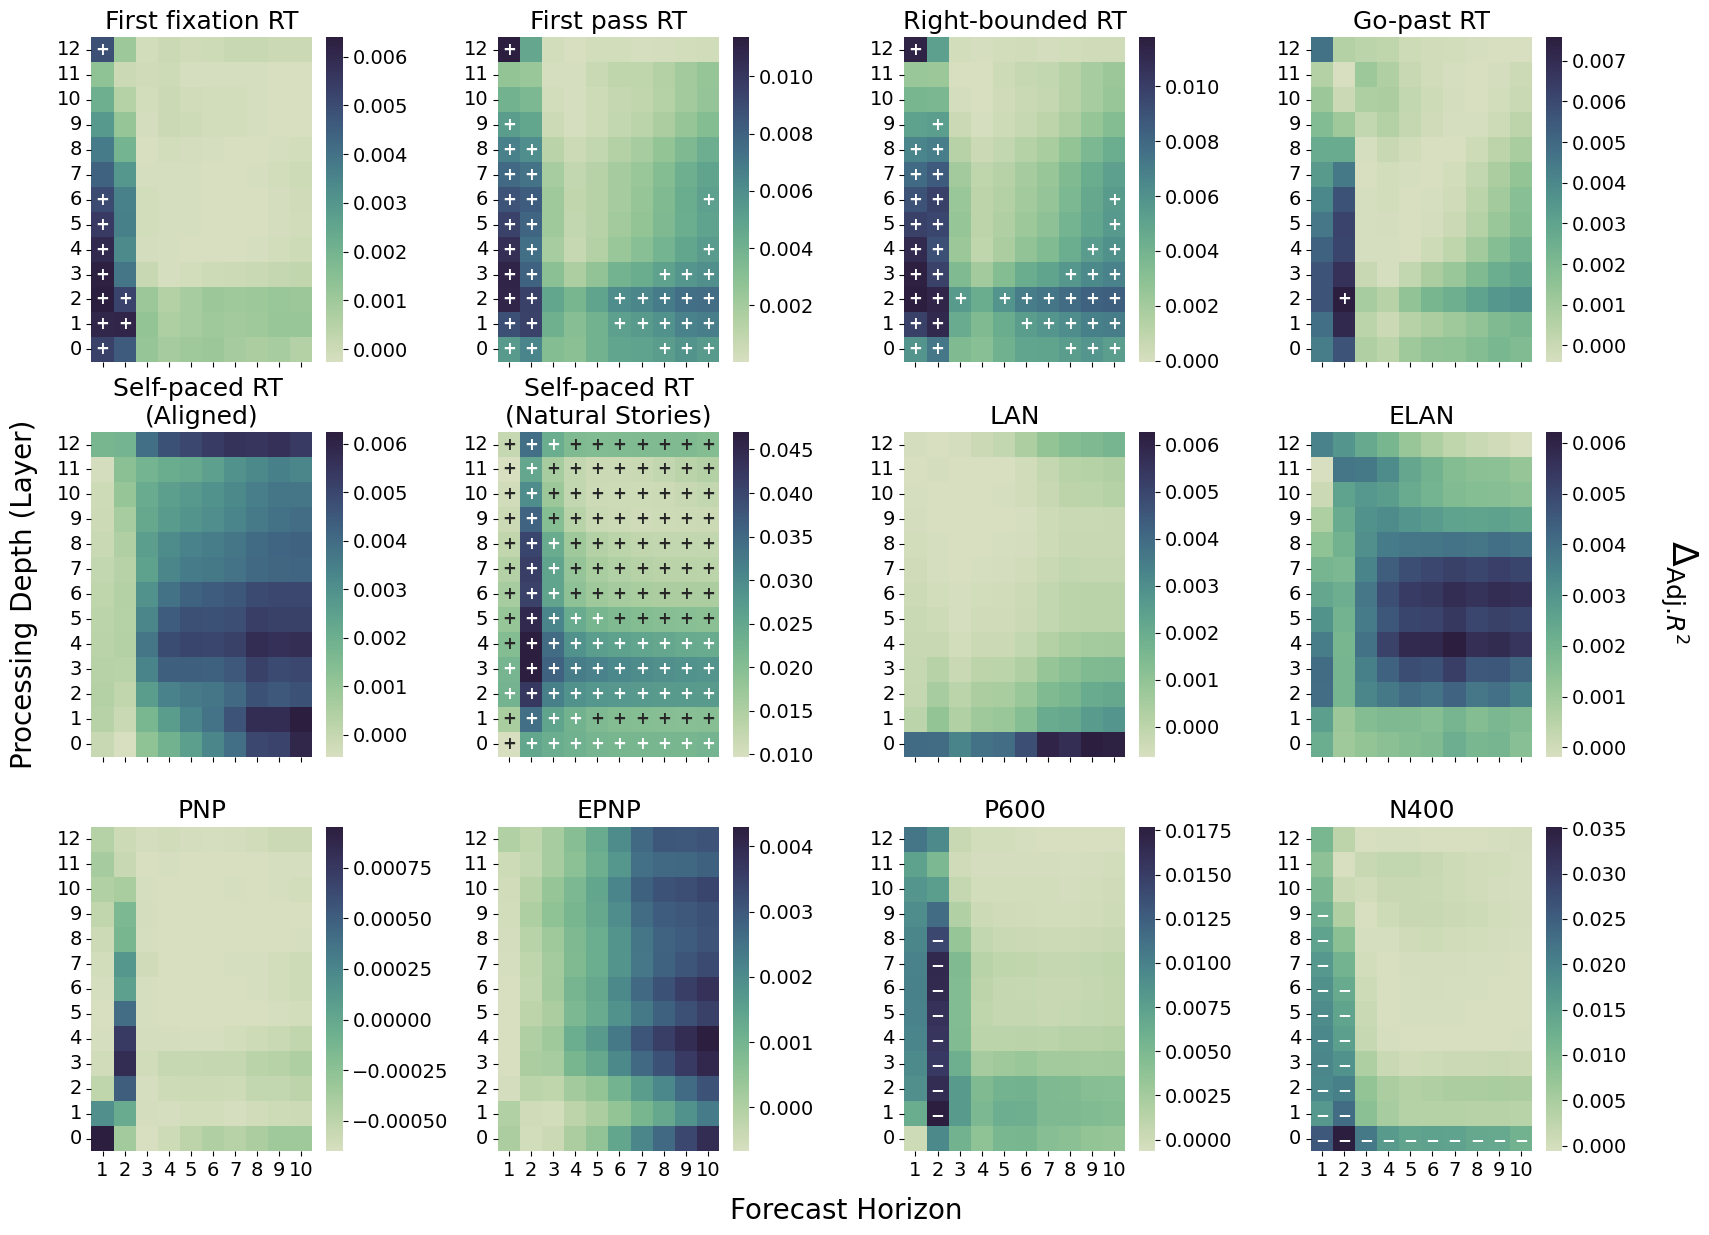

<Figure size 2200x1400 with 0 Axes>

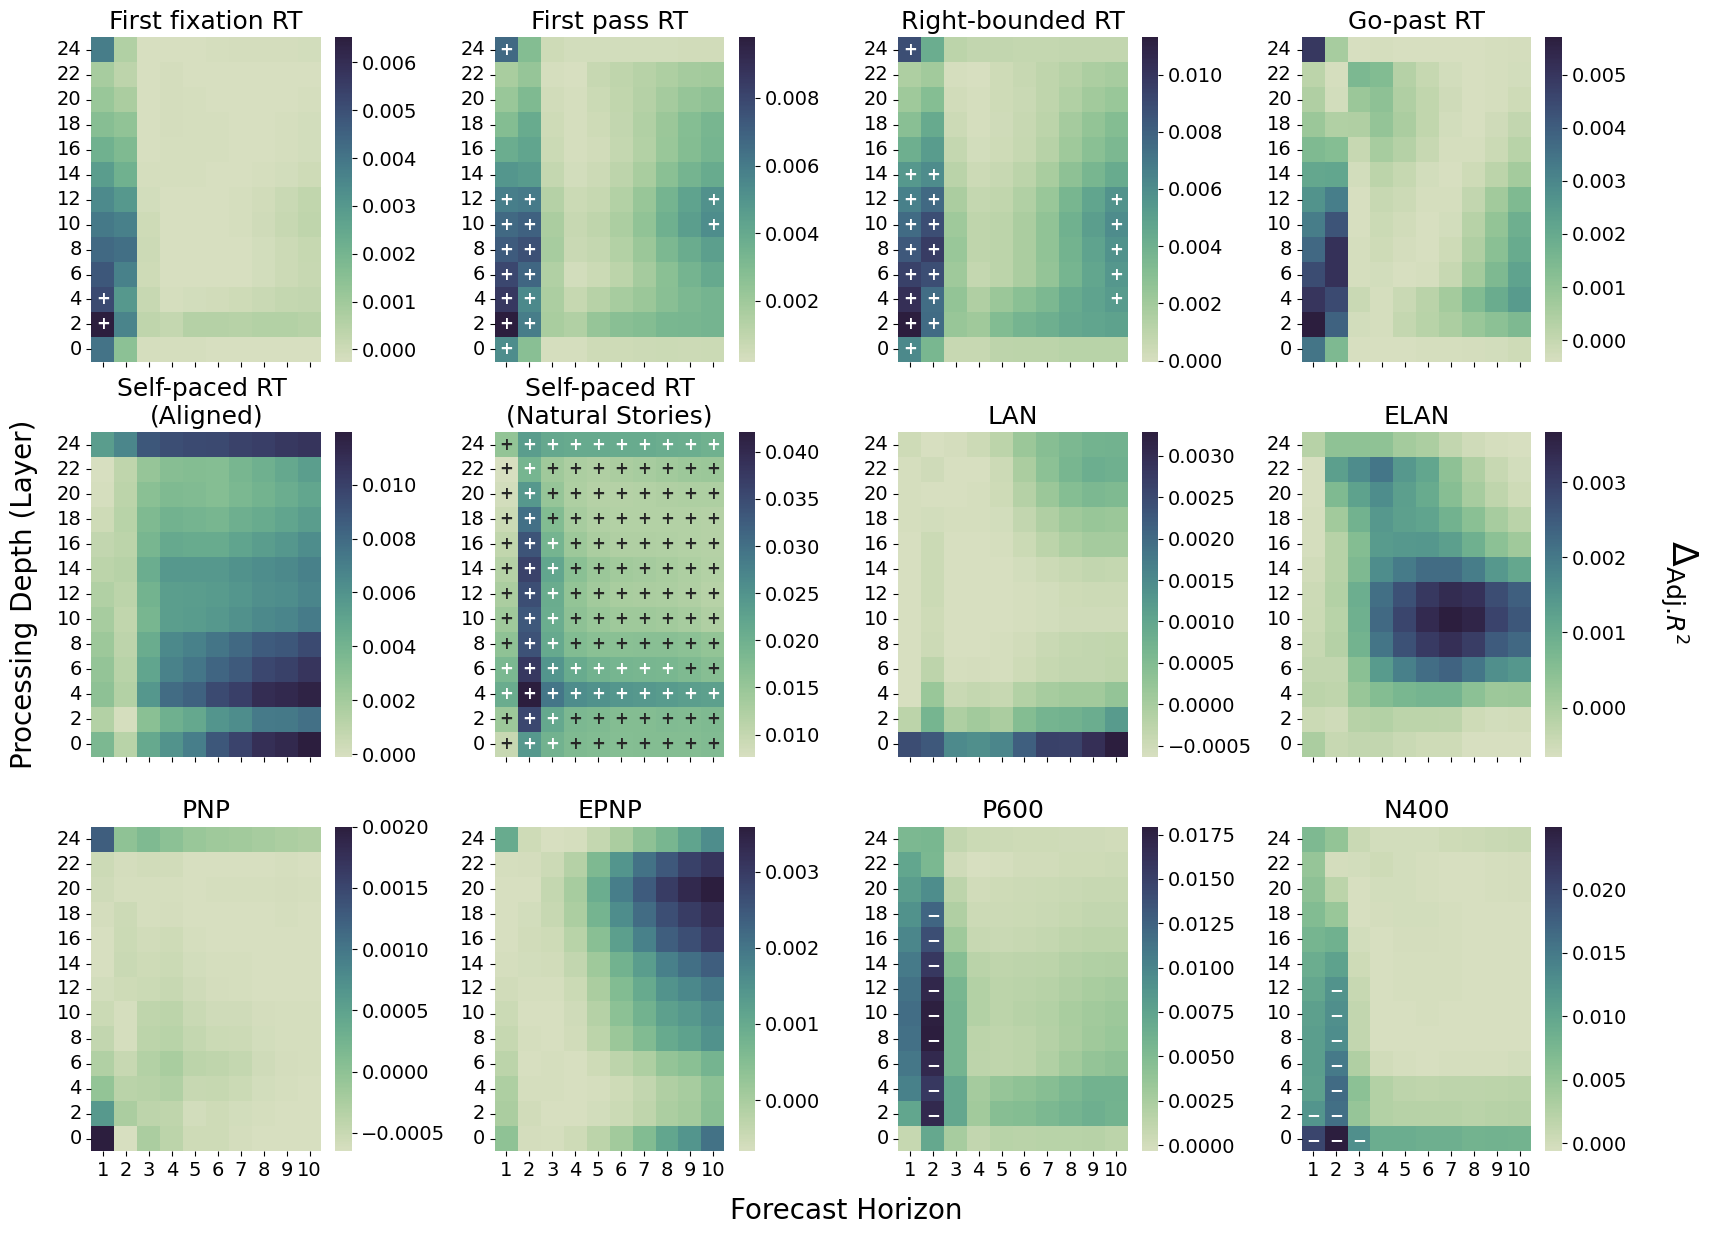

<Figure size 2200x1400 with 0 Axes>

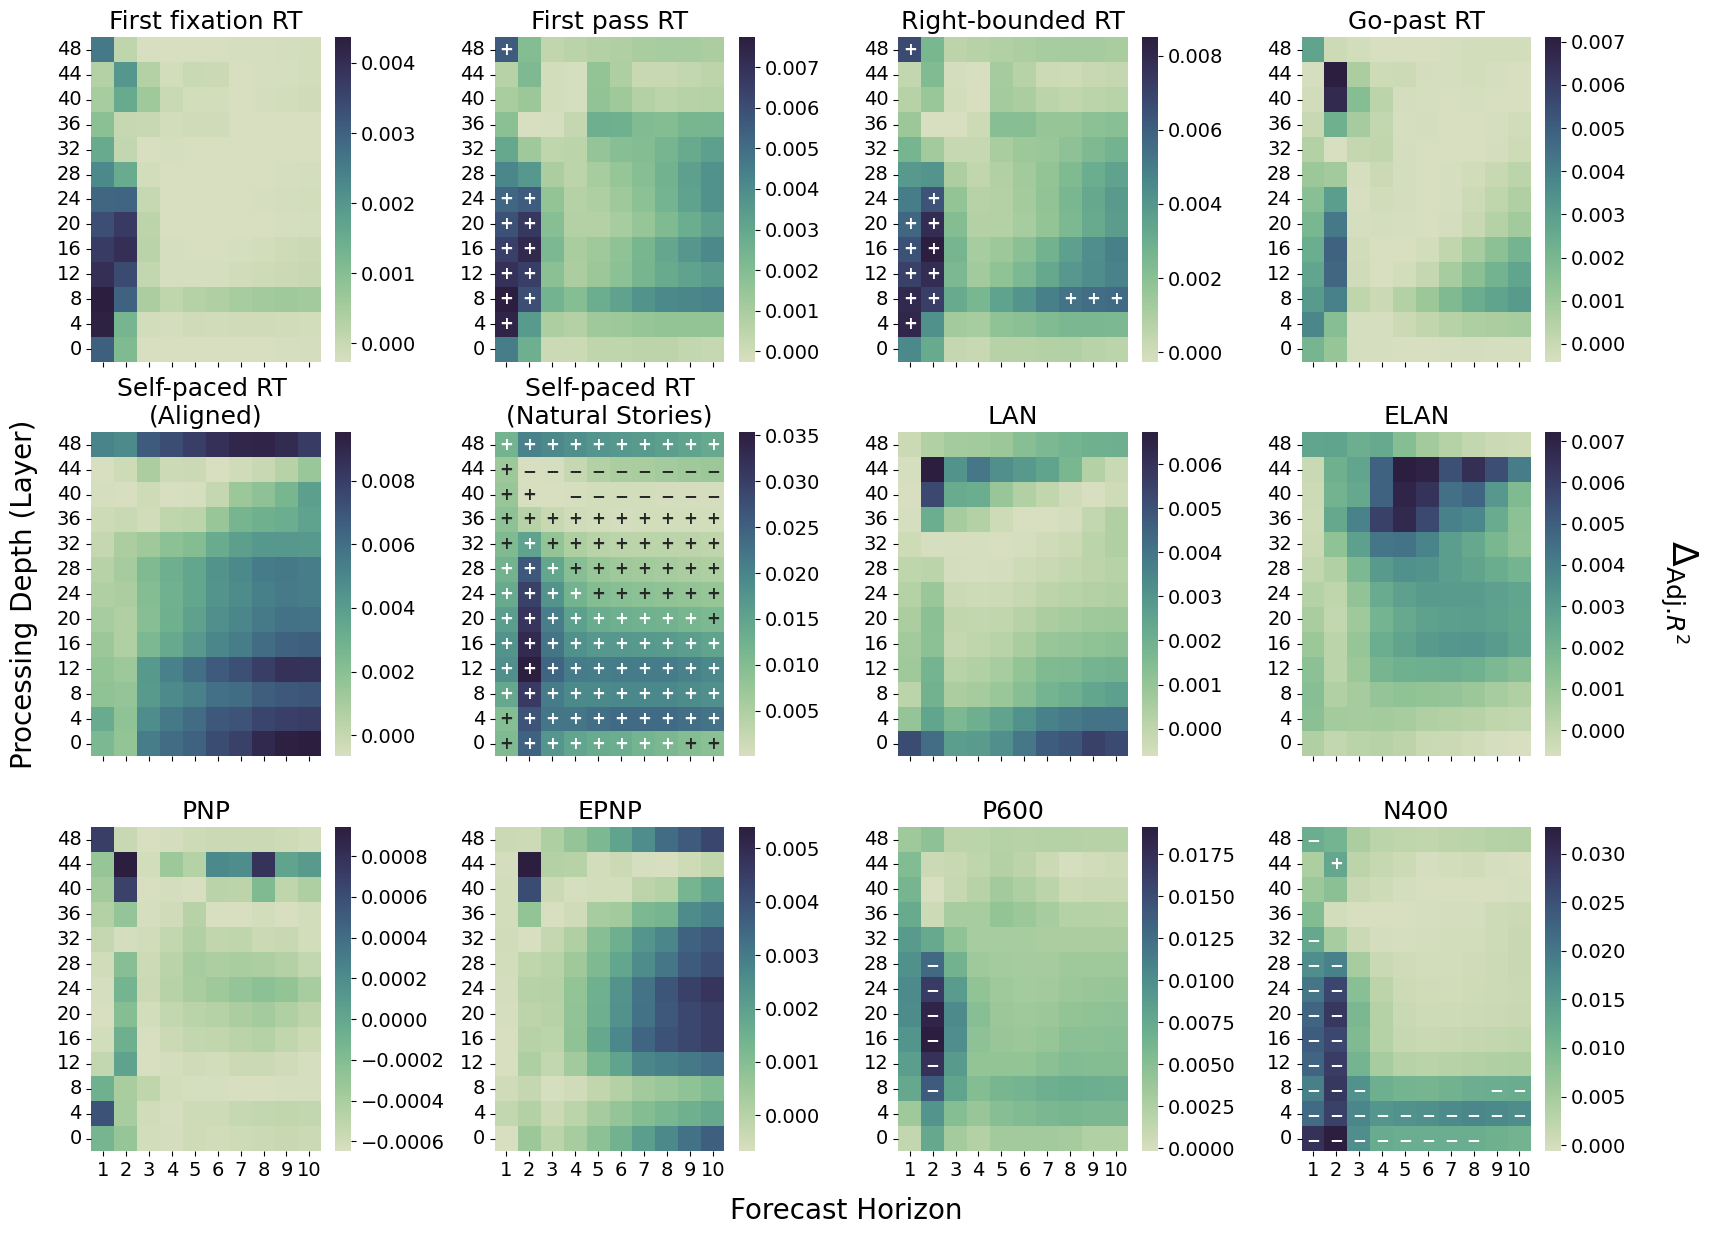

<Figure size 2200x1400 with 0 Axes>

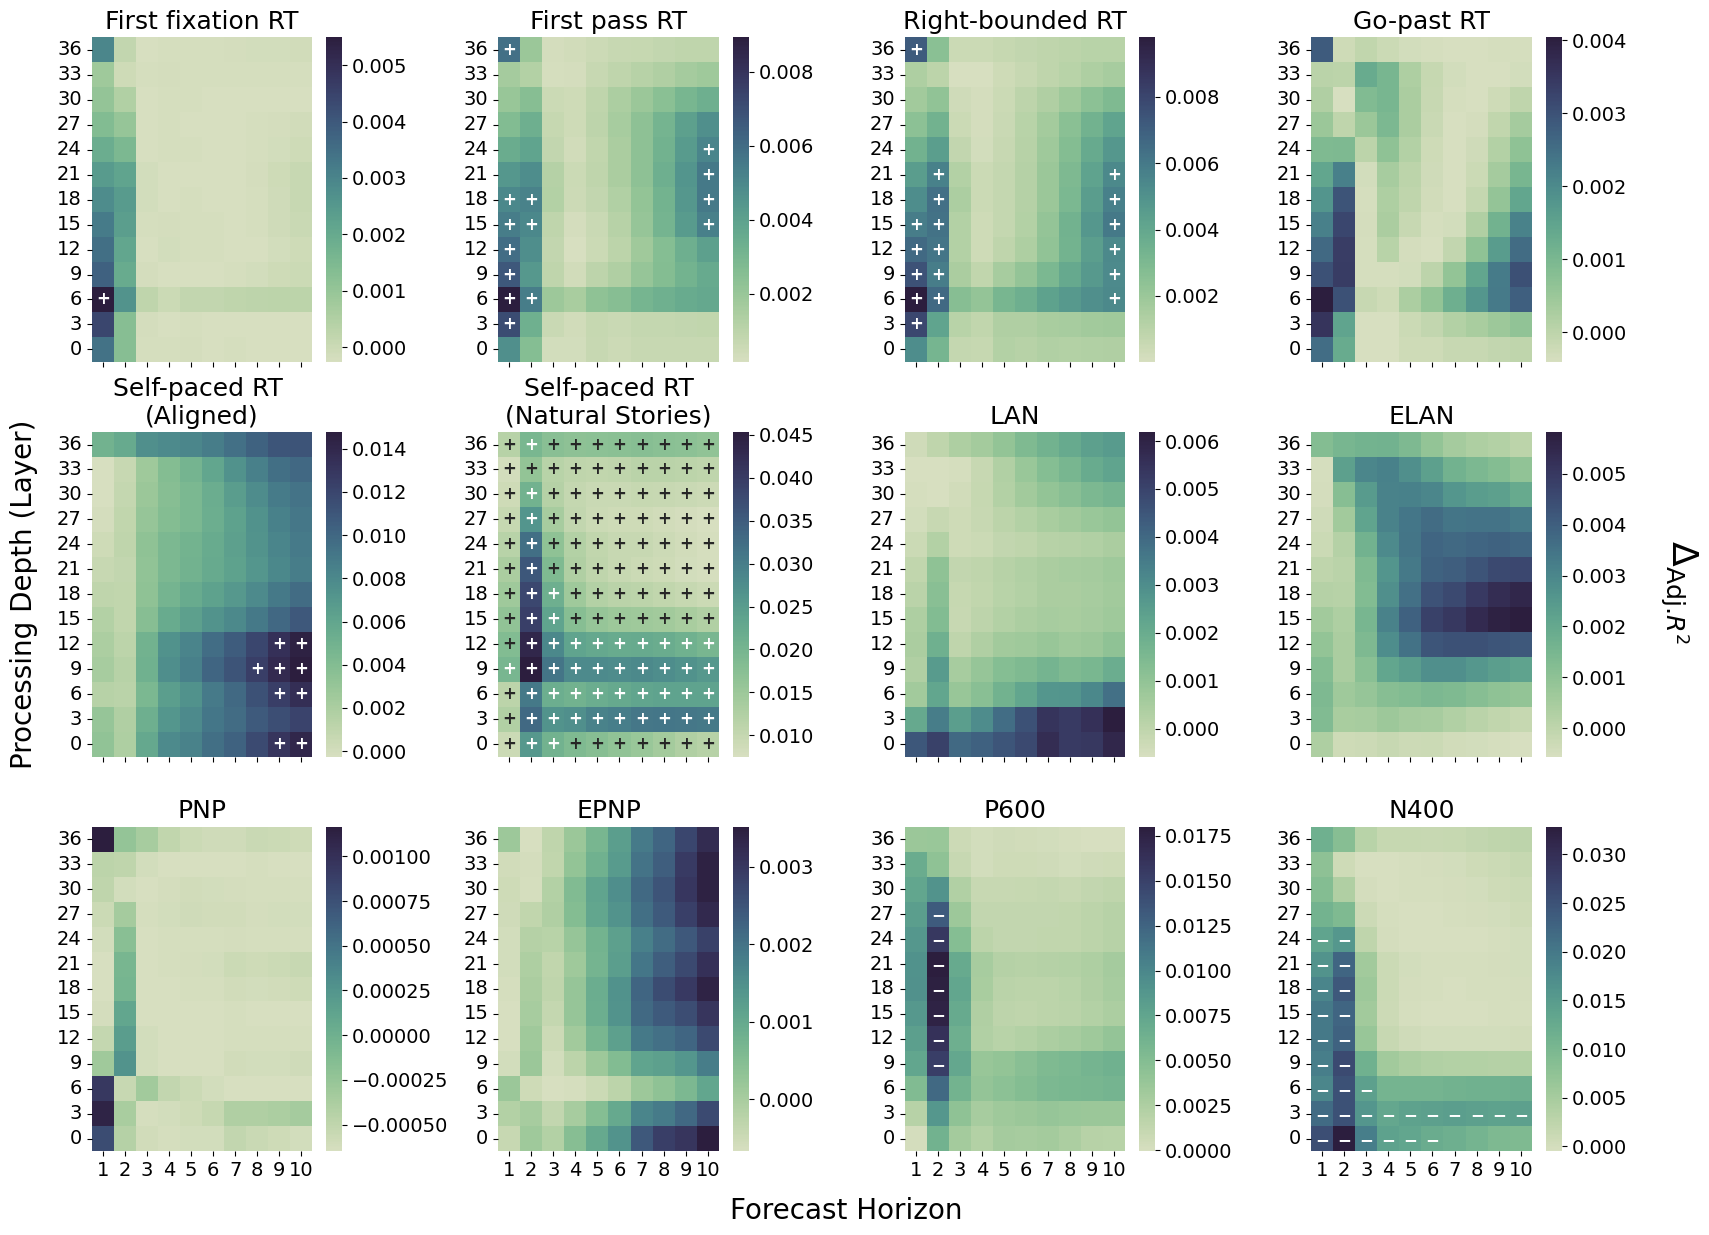

In [39]:
target_measurements = [
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT',
    'LAN', 'ELAN', 'PNP', 'EPNP', 'P600', 'N400'
    ]

for model_size in ['Small', 'Medium', 'XL', 'Large']:
    plt.figure(figsize=(22, 14))

    data_to_plot = individual_predictors_all[
        (individual_predictors_all['model'] == f'GPT-2 {model_size}') &
        (individual_predictors_all['baseline'] == 'Control') &  #'Control + Surprisal') &  #'Control') &
        (individual_predictors_all['y'].isin(target_measurements)) &
        (individual_predictors_all['fold'] == 'full')
    ]

    # order entries according to their order in target_measurements
    # data_to_plot = data_to_plot.sort_values(by=['y'])

    g = sns.FacetGrid(data_to_plot, col='y', height=4, col_wrap=4, margin_titles=False, sharey=False, col_order=target_measurements)


    def plot_subplot(data, **kwargs):
        matrix = np.zeros((len(data.layer.unique()), len(data.horizon.unique())))
        labels_matrix = np.zeros_like(matrix).tolist()
        for j, layer in enumerate(data.layer.unique()[::-1]):
            for k, horizon in enumerate(data.horizon.unique()):
                tmp_df = data[
                    (data.layer == layer) &
                    (data.horizon == horizon)
                ]

                matrix[j, k] = tmp_df["delta_rsquared_adj"].item()
                if tmp_df["significant"].item():
                    labels_matrix[j][k] = "$\\boldsymbol{+}$" if tmp_df["ias_coef"].item() > 0 else "$\\boldsymbol{-}$"
                else:
                    labels_matrix[j][k] = ""

        ax = sns.heatmap(
            matrix, 
            ax=plt.gca(), 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            # vmin=data.delta_rsquared_adj.min(), #min_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else min_delta_rsq_adj_control_surprisal,
            # vmax=data.delta_rsquared_adj.max(),  #max_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else max_delta_rsq_adj_control_surprisal,
            annot = labels_matrix,
            annot_kws={"size": 12, 'weight':'bold'},
            fmt="s",
            xticklabels=data.horizon.unique(),
            yticklabels=data.layer.unique()[::-1],
            # cbar=True if data.y.unique()[0] == 'rating_mean' else False,
            # square=True,
        )

        # if y is PNP, round color bar ticks to 4 decimal places
        # if data.y.unique()[0] == 'PNP':
        #     cbar = ax.collections[0].colorbar
        #     cbar.set_ticks([round(i, 4) for i in cbar.get_ticks()])

        # plt.title(f'{y_labels[data.y.unique()[0]]}', fontsize=16)

        # change font size of x and y ticks
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14, rotation=0)

        # change font size of colorbar
        ax.figure.axes[-1].tick_params(labelsize=14)

    # Map the function to each subplot
    g.map_dataframe(plot_subplot)

    # Adjust labels and legend
    g.set_axis_labels('', '')

    # set title
    for ax, y in zip(g.axes.flat, target_measurements):
        ax.set_title(y_labels[y], fontsize=18)
        
    g.fig.text(0.43, -0.02, s='Forecast Horizon',fontdict={'fontsize':20})
    g.fig.text(-0.02, 0.36, s='Processing Depth (Layer)',fontdict={'fontsize':20}, rotation=90)
    g.fig.text(1.01, 0.47, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':26}, rotation=270)
    # g.fig.text(1.005, 0.06, s='Baseline = Control + Surprisal',fontdict={'fontsize':16}, rotation=270)
    # g.fig.text(1.005, 0.60, s='Baseline = Control',fontdict={'fontsize':16}, rotation=270)

    plt.tight_layout()
    plt.savefig(f'figures/revision2/individual_predictors_difficulty_control_baseline_{model_size.lower()}.pdf', bbox_inches='tight')
    # plt.savefig(f'figures/revision2/individual_predictors_difficulty_surprisal_baseline_{model_size.lower()}.pdf', bbox_inches='tight')
    plt.show()


    

In [ ]:
target_measurements = [
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT',
    'LAN', 'ELAN', 'PNP', 'EPNP', 'P600', 'N400'
    ]

for model_size in ['Small', 'Medium', 'XL', 'Large']:
    plt.figure(figsize=(22, 14))

    data_to_plot = individual_predictors_all[
        (individual_predictors_all['model'] == f'GPT-2 {model_size}') &
        (individual_predictors_all['baseline'] == 'Control') &  #'Control + Surprisal') &  #'Control') &
        (individual_predictors_all['y'].isin(target_measurements))
    ]

    # order entries according to their order in target_measurements
    # data_to_plot = data_to_plot.sort_values(by=['y'])

    g = sns.FacetGrid(data_to_plot, col='y', height=4, col_wrap=4, margin_titles=False, sharey=False, col_order=target_measurements)


    def plot_subplot(data, **kwargs):
        matrix = np.zeros((len(data.layer.unique()), len(data.horizon.unique())))
        labels_matrix = np.zeros_like(matrix).tolist()
        for j, layer in enumerate(data.layer.unique()[::-1]):
            for k, horizon in enumerate(data.horizon.unique()):
                tmp_df = data[
                    (data.layer == layer) &
                    (data.horizon == horizon)
                ]

                matrix[j, k] = tmp_df["delta_loglik"].item()
                if tmp_df["significant"].item():
                    labels_matrix[j][k] = "$\\boldsymbol{+}$" if tmp_df["ias_coef"].item() > 0 else "$\\boldsymbol{-}$"
                else:
                    labels_matrix[j][k] = ""

        ax = sns.heatmap(
            matrix, 
            ax=plt.gca(), 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
            # vmin=data.delta_rsquared_adj.min(), #min_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else min_delta_rsq_adj_control_surprisal,
            # vmax=data.delta_rsquared_adj.max(),  #max_delta_rsq_adj_control if data.baseline.unique()[0] == 'Control' else max_delta_rsq_adj_control_surprisal,
            annot = labels_matrix,
            annot_kws={"size": 12, 'weight':'bold'},
            fmt="s",
            xticklabels=data.horizon.unique(),
            yticklabels=data.layer.unique()[::-1],
            # cbar=True if data.y.unique()[0] == 'rating_mean' else False,
            # square=True,
        )

        # if y is PNP, round color bar ticks to 4 decimal places
        # if data.y.unique()[0] == 'PNP':
        #     cbar = ax.collections[0].colorbar
        #     cbar.set_ticks([round(i, 4) for i in cbar.get_ticks()])

        # plt.title(f'{y_labels[data.y.unique()[0]]}', fontsize=16)

        # change font size of x and y ticks
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14, rotation=0)

        # change font size of colorbar
        ax.figure.axes[-1].tick_params(labelsize=14)

    # Map the function to each subplot
    g.map_dataframe(plot_subplot)

    # Adjust labels and legend
    g.set_axis_labels('', '')

    # set title
    for ax, y in zip(g.axes.flat, target_measurements):
        ax.set_title(y_labels[y], fontsize=18)
        
    g.fig.text(0.43, -0.02, s='Forecast Horizon',fontdict={'fontsize':20})
    g.fig.text(-0.02, 0.36, s='Processing Depth (Layer)',fontdict={'fontsize':20}, rotation=90)
    g.fig.text(1.01, 0.47, s='$\Delta_{\\mathcal{L}}$',fontdict={'fontsize':26}, rotation=270)
    # g.fig.text(1.005, 0.06, s='Baseline = Control + Surprisal',fontdict={'fontsize':16}, rotation=270)
    # g.fig.text(1.005, 0.60, s='Baseline = Control',fontdict={'fontsize':16}, rotation=270)

    plt.tight_layout()
    plt.savefig(f'figures/revision2/individual_predictors_difficulty_control_baseline_{model_size.lower()}_loglik.pdf', bbox_inches='tight')
    # plt.savefig(f'figures/revision2/individual_predictors_difficulty_surprisal_baseline_{model_size.lower()}.pdf', bbox_inches='tight')
    plt.show()


    

-----
### Layer-wise

In [83]:
# Load the dataframes
layer_predictors_replace_surprisal_devarda = pd.read_csv("results/ols_aligned_ias_cosine_std_layer_against_surprisal.csv")
layer_predictors_replace_surprisal_ns = pd.read_csv("results/ols_ns_ias_cosine_std_layer_against_surprisal.csv")

# Load the dataframes
layer_predictors_devarda = pd.read_csv("results/ols_aligned_ias_cosine_std_layer_against_control.csv")
layer_predictors_ns = pd.read_csv("results/ols_ns_ias_cosine_std_layer_against_control.csv")

# Fix the distance metric
assert len(layer_predictors_replace_surprisal_devarda["dist_metric"].unique()) == 1 and layer_predictors_replace_surprisal_devarda["dist_metric"].unique()[0] == 'cosine_std'
assert len(layer_predictors_devarda["dist_metric"].unique()) == 1 and layer_predictors_devarda["dist_metric"].unique()[0] == 'cosine_std'
assert len (layer_predictors_replace_surprisal_ns["dist_metric"].unique()) == 1 and layer_predictors_replace_surprisal_ns["dist_metric"].unique()[0] == 'cosine_std'
assert len(layer_predictors_devarda["dist_metric"].unique()) == 1 and layer_predictors_devarda["dist_metric"].unique()[0] == 'cosine_std'


# Perform the Holm-Bonferroni correction
alpha = 0.05

layer_predictors_replace_surprisal_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(layer_predictors_replace_surprisal_devarda, 'anova_p', alpha)
layer_predictors_replace_surprisal_devarda.loc[retained_indices_aligned, 'significant'] = True

layer_predictors_replace_surprisal_ns['significant'] = False
retained_indices_ns = holm_bonferroni(layer_predictors_replace_surprisal_ns, 'anova_p', alpha)
layer_predictors_replace_surprisal_ns.loc[retained_indices_ns, 'significant'] = True

layer_predictors_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(layer_predictors_devarda, 'anova_p', alpha)
layer_predictors_devarda.loc[retained_indices_aligned, 'significant'] = True

layer_predictors_ns['significant'] = False
retained_indices_ns = holm_bonferroni(layer_predictors_ns, 'anova_p', alpha)
layer_predictors_ns.loc[retained_indices_ns, 'significant'] = True




# Merge the dataframes
layer_predictors_replace_surprisal_devarda["corpus"] = "DeVarda"
layer_predictors_replace_surprisal_ns["corpus"] = "Natural Stories"
layer_predictors_replace_surprisal = pd.concat([layer_predictors_replace_surprisal_devarda, layer_predictors_replace_surprisal_ns])
# layer_predictors_replace_surprisal = layer_predictors_replace_surprisal_devarda

layer_predictors_devarda["corpus"] = "DeVarda"
layer_predictors_ns["corpus"] = "Natural Stories"
layer_predictors = pd.concat([layer_predictors_devarda, layer_predictors_ns])
# layer_predictors = layer_predictors_devarda

layer_predictors_replace_surprisal['baseline'] = 'Control + Surprisal'
layer_predictors['baseline'] = 'Control'

layer_predictors_all = pd.concat([layer_predictors_replace_surprisal, layer_predictors])


# Add human-readable names to the dataframes
layer_predictors_all['aggregation_name'] = layer_predictors_all['aggregation'].map(rename_aggregation_dict)
layer_predictors_all['model'] = layer_predictors_all['model'].map(rename_model_dict)

# Add layer depth to the dataframe
layer_depth = []
for _, row in layer_predictors_all.iterrows():
    if row.metric == 'Surprisal' or row.layer == 'All':
        layer_depth.append(None)
        continue
    if row.model == 'GPT-2 Small':
        layer_depth.append(str(int(round(100 * int(row.layer) / 12))))
    elif row.model == 'GPT-2 Medium':
        layer_depth.append(str(int(round(100 * int(row.layer) / 24))))
    elif row.model == 'GPT-2 Large':
        layer_depth.append(str(int(round(100 * int(row.layer) / 36))))
    elif row.model == 'GPT-2 XL':
        layer_depth.append(str(int(round(100 * int(row.layer) / 48))))
    else:
        layer_depth.append(None)
layer_predictors_all['layer_depth'] = layer_depth


<>:93: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/1480772353.py:93: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(-0.03, 0.49, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/1480772353.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/1480772353.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/i

<Figure size 1600x1200 with 0 Axes>

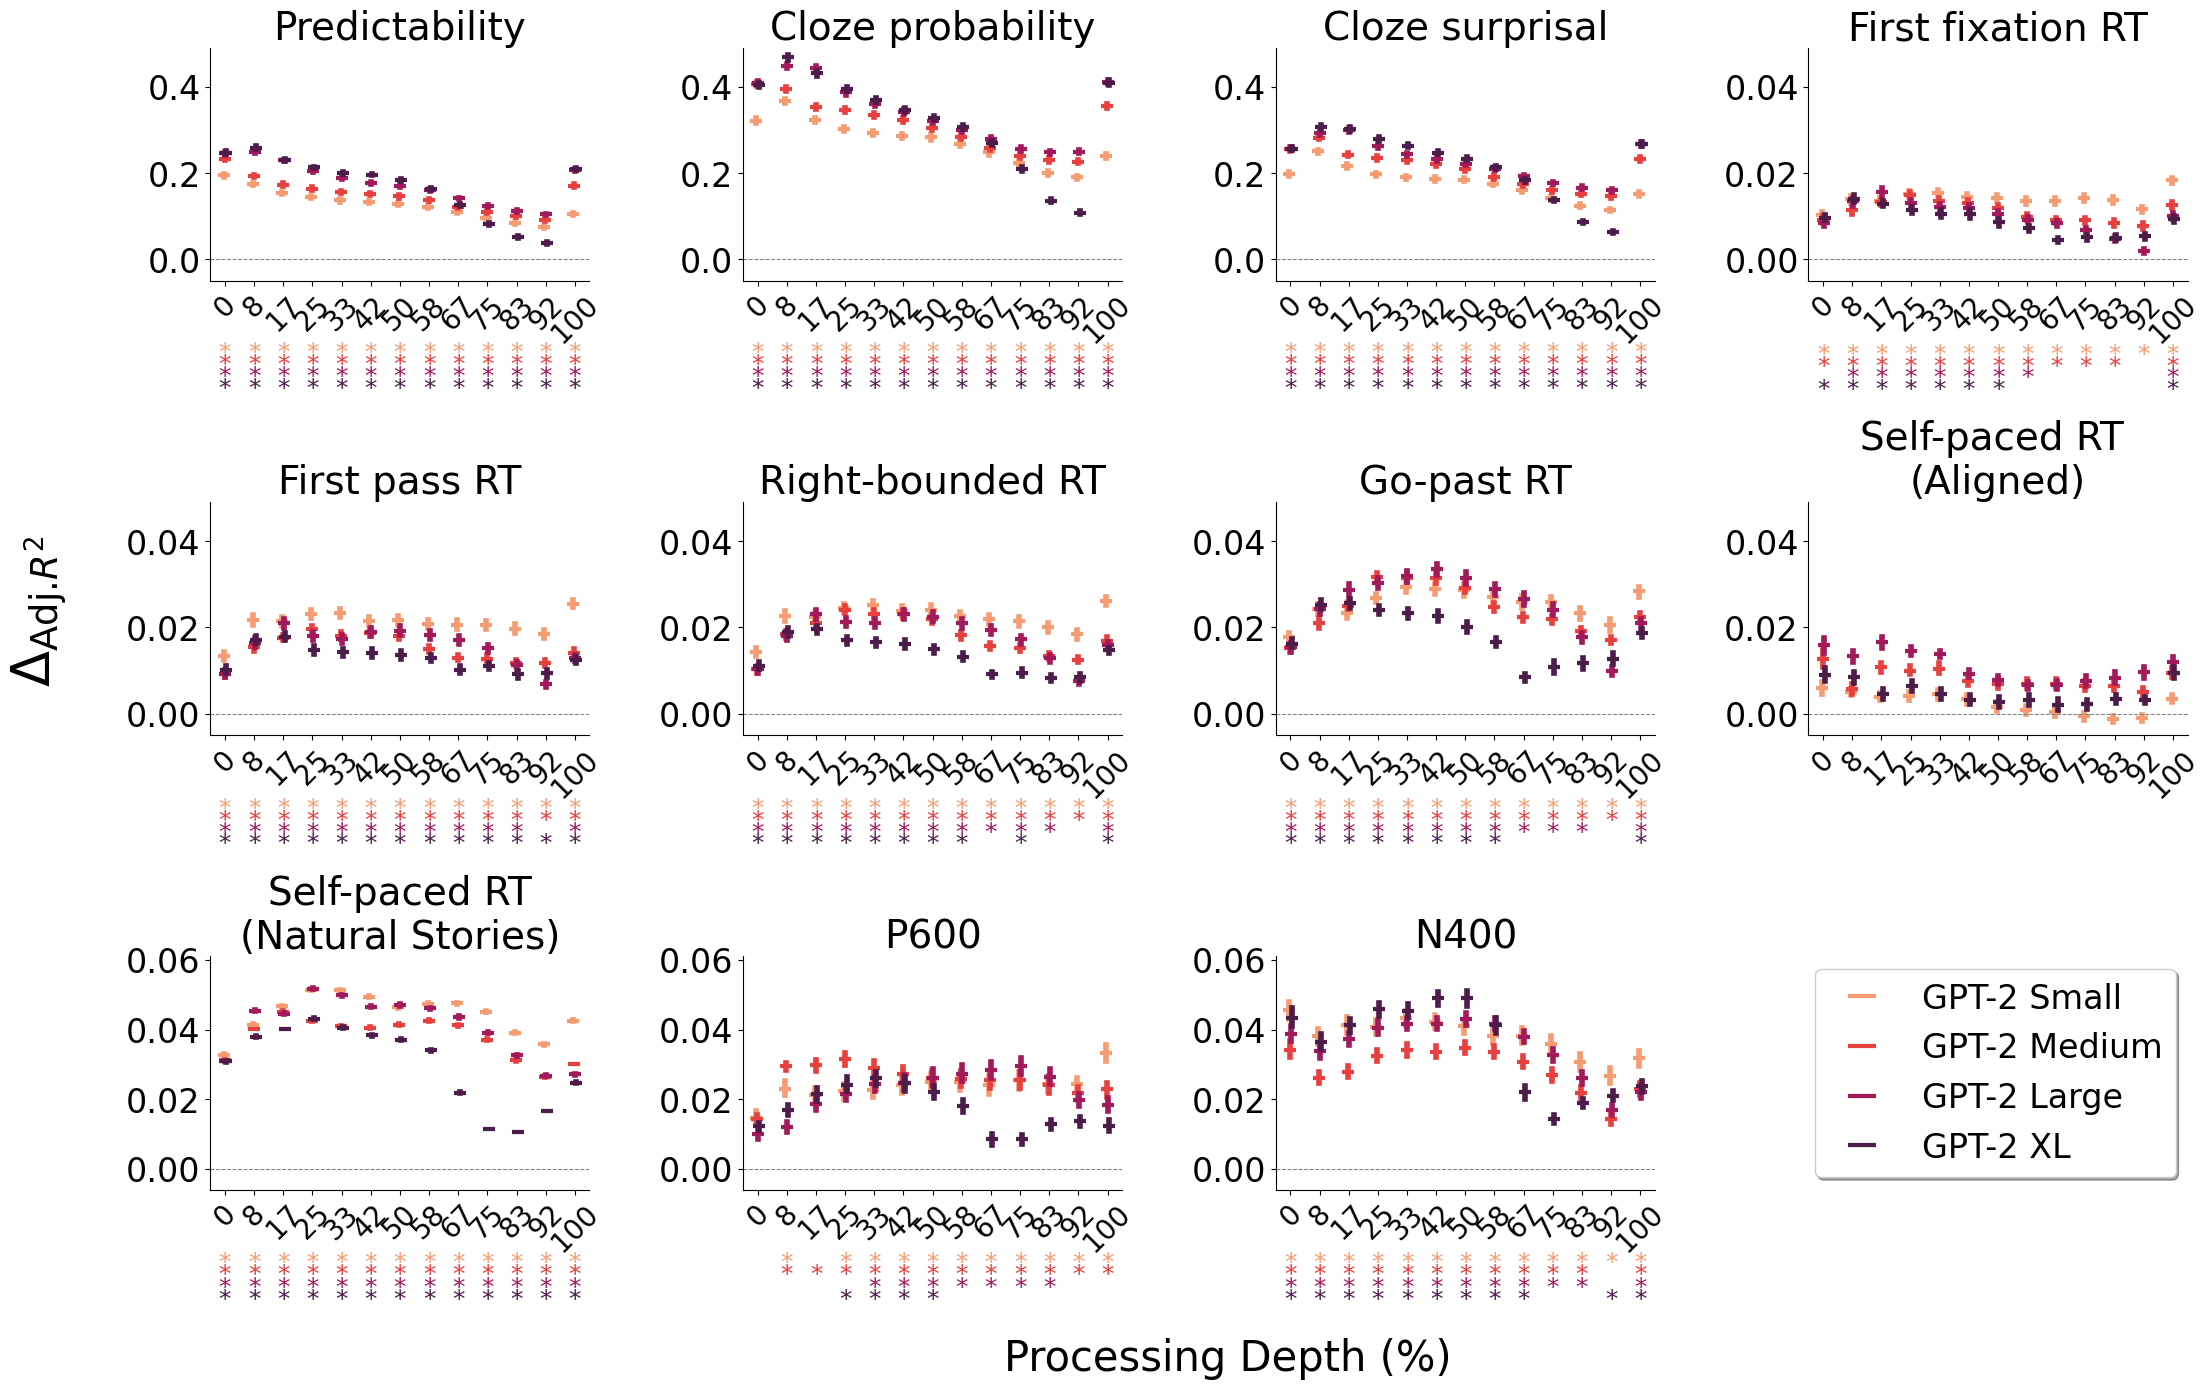

In [102]:
LAYERS = {
    "GPT-2 Small": list(range(0, 13)),
    "GPT-2 Medium": list(range(0, 25, 2)),
    "GPT-2 Large": list(range(0, 37, 3)),
    "GPT-2 XL": list(range(0, 49, 4))
}

# matplotlib.rcParams.update({'font.size': 28})
_palette = sns.color_palette("rocket_r", 4)

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT', 
    'P600', 'N400'
]

df = layer_predictors_all[
    # (~ layer_predictors_all.y.isin(['sdItemRT', 'entropy', 'rating_sd'])) &
    (layer_predictors_all.y.isin(target_measurements)) &
    (layer_predictors_all.baseline == 'Control')
]

plt.figure(figsize=(16, 12))

g = sns.FacetGrid(df, col='y', col_wrap=4, height=4.5, sharey=False, sharex=False, col_order=target_measurements)

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon == 'All') &
        (data.layer != 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='layer_depth', y='delta_rsquared_adj', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
        plt.ylim(-0.05, 0.49)
    elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
        plt.ylim(-0.005, 0.049)
    elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
        plt.ylim(-0.005, 0.021)
    elif col in [ 'meanItemRT', 'P600', 'N400']:
        plt.ylim(-0.006, 0.061)
        
    plt.xticks(rotation=45, ha='center', fontsize=20)
    plt.yticks(fontsize=24)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, layer in enumerate(LAYERS[model]):
            significant = data[
                (data.fold == 'full') &
                (data.horizon == 'All') &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.layer == layer)
            ].significant.values[0]

            significance_label = '*' if significant else '' 
            
            if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
                plt.text(j, -0.215 - i * 0.028, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
                plt.text(j, -0.022 - i * 0.0027, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
                plt.text(j, -0.008 - i * 0.001, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            elif col in [ 'meanItemRT', 'P600', 'N400']:
                plt.text(j, -0.027 - i * 0.0035, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.98, 0.19), fontsize=24, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)
    
g.fig.text(0.43, -0.03, s='Processing Depth (%)',fontdict={'fontsize':30})
g.fig.text(-0.03, 0.49, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/revision2/layer_predictors_against_control_baseline.pdf', bbox_inches='tight')

# Show plot
plt.show()


In [ ]:
LAYERS = {
    "GPT-2 Small": list(range(0, 13)),
    "GPT-2 Medium": list(range(0, 25, 2)),
    "GPT-2 Large": list(range(0, 37, 3)),
    "GPT-2 XL": list(range(0, 49, 4))
}

# matplotlib.rcParams.update({'font.size': 28})
_palette = sns.color_palette("rocket_r", 4)

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT', 
    'P600', 'N400'
]

df = layer_predictors_all[
    # (~ layer_predictors_all.y.isin(['sdItemRT', 'entropy', 'rating_sd'])) &
    (layer_predictors_all.y.isin(target_measurements)) &
    (layer_predictors_all.baseline == 'Control')
]

plt.figure(figsize=(16, 12))

g = sns.FacetGrid(df, col='y', col_wrap=4, height=4.5, sharey=False, sharex=False, col_order=target_measurements)

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon == 'All') &
        (data.layer != 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='layer_depth', y='delta_loglik', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
    #     plt.ylim(-0.05, 0.49)
    # elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
    #     plt.ylim(-0.005, 0.049)
    # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
    #     plt.ylim(-0.005, 0.021)
    # elif col in [ 'meanItemRT', 'P600', 'N400']:
    #     plt.ylim(-0.006, 0.061)
        
    plt.xticks(rotation=45, ha='center', fontsize=20)
    plt.yticks(fontsize=24)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, layer in enumerate(LAYERS[model]):
            significant = data[
                (data.fold == 'full') &
                (data.horizon == 'All') &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.layer == layer)
            ].significant.values[0]

            significance_label = '*' if significant else '' 
            
            # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
            #     plt.text(j, -0.215 - i * 0.028, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            # elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
            #     plt.text(j, -0.022 - i * 0.0027, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
            #     plt.text(j, -0.008 - i * 0.001, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            # elif col in [ 'meanItemRT', 'P600', 'N400']:
            #     plt.text(j, -0.027 - i * 0.0035, significance_label, ha='center', va='center', color=_palette[i], fontsize=18)
            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.98, 0.19), fontsize=24, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)
    
g.fig.text(0.43, -0.03, s='Processing Depth (%)',fontdict={'fontsize':30})
g.fig.text(-0.03, 0.49, s='$\Delta_{\\mathcal{L}}$',fontdict={'fontsize':38}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/revision2/layer_predictors_against_control_baseline_loglik.pdf', bbox_inches='tight')

# Show plot
plt.show()


-----
### Horizon-wise

In [55]:
# Load the dataframes
horizon_predictors_replace_surprisal_devarda = pd.read_csv("results/ols_aligned_ias_cosine_std_horizon_against_surprisal.csv")
horizon_predictors_replace_surprisal_ns = pd.read_csv("results/ols_ns_ias_cosine_std_horizon_against_surprisal.csv")

# Load the dataframes
horizon_predictors_devarda = pd.read_csv("results/ols_aligned_ias_cosine_std_horizon_against_control.csv")
horizon_predictors_ns = pd.read_csv("results/ols_ns_ias_cosine_std_horizon_against_control.csv")

# Fix the distance metric
assert len(horizon_predictors_replace_surprisal_devarda["dist_metric"].unique()) == 1 and horizon_predictors_replace_surprisal_devarda["dist_metric"].unique()[0] == 'cosine_std'
assert len(horizon_predictors_devarda["dist_metric"].unique()) == 1 and horizon_predictors_devarda["dist_metric"].unique()[0] == 'cosine_std'
assert len (horizon_predictors_replace_surprisal_ns["dist_metric"].unique()) == 1 and horizon_predictors_replace_surprisal_ns["dist_metric"].unique()[0] == 'cosine_std'
assert len(horizon_predictors_devarda["dist_metric"].unique()) == 1 and horizon_predictors_devarda["dist_metric"].unique()[0] == 'cosine_std'


# Perform the Holm-Bonferroni correction
alpha = 0.05

horizon_predictors_replace_surprisal_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(horizon_predictors_replace_surprisal_devarda, 'anova_p', alpha)
horizon_predictors_replace_surprisal_devarda.loc[retained_indices_aligned, 'significant'] = True

horizon_predictors_replace_surprisal_ns['significant'] = False
retained_indices_ns = holm_bonferroni(horizon_predictors_replace_surprisal_ns, 'anova_p', alpha)
horizon_predictors_replace_surprisal_ns.loc[retained_indices_ns, 'significant'] = True

horizon_predictors_devarda['significant'] = False
retained_indices_aligned = holm_bonferroni(horizon_predictors_devarda, 'anova_p', alpha)
horizon_predictors_devarda.loc[retained_indices_aligned, 'significant'] = True

horizon_predictors_ns['significant'] = False
retained_indices_ns = holm_bonferroni(horizon_predictors_ns, 'anova_p', alpha)
horizon_predictors_ns.loc[retained_indices_ns, 'significant'] = True


# Merge the dataframes
horizon_predictors_replace_surprisal_devarda["corpus"] = "DeVarda"
horizon_predictors_replace_surprisal_ns["corpus"] = "Natural Stories"
horizon_predictors_replace_surprisal = pd.concat([horizon_predictors_replace_surprisal_devarda, horizon_predictors_replace_surprisal_ns])

horizon_predictors_devarda["corpus"] = "DeVarda"
horizon_predictors_ns["corpus"] = "Natural Stories"
horizon_predictors = pd.concat([horizon_predictors_devarda, horizon_predictors_ns])

horizon_predictors_replace_surprisal['baseline'] = 'Control + Surprisal'
horizon_predictors['baseline'] = 'Control'

horizon_predictors_all = pd.concat([horizon_predictors_replace_surprisal, horizon_predictors])

# Add human-readable names to the dataframes
horizon_predictors_all['aggregation_name'] = horizon_predictors_all['aggregation'].map(rename_aggregation_dict)
horizon_predictors_all['model'] = horizon_predictors_all['model'].map(rename_model_dict)


<>:93: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/3342368707.py:93: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(-0.03, 0.49, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/3342368707.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_63303/3342368707.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/i

<Figure size 1600x1200 with 0 Axes>

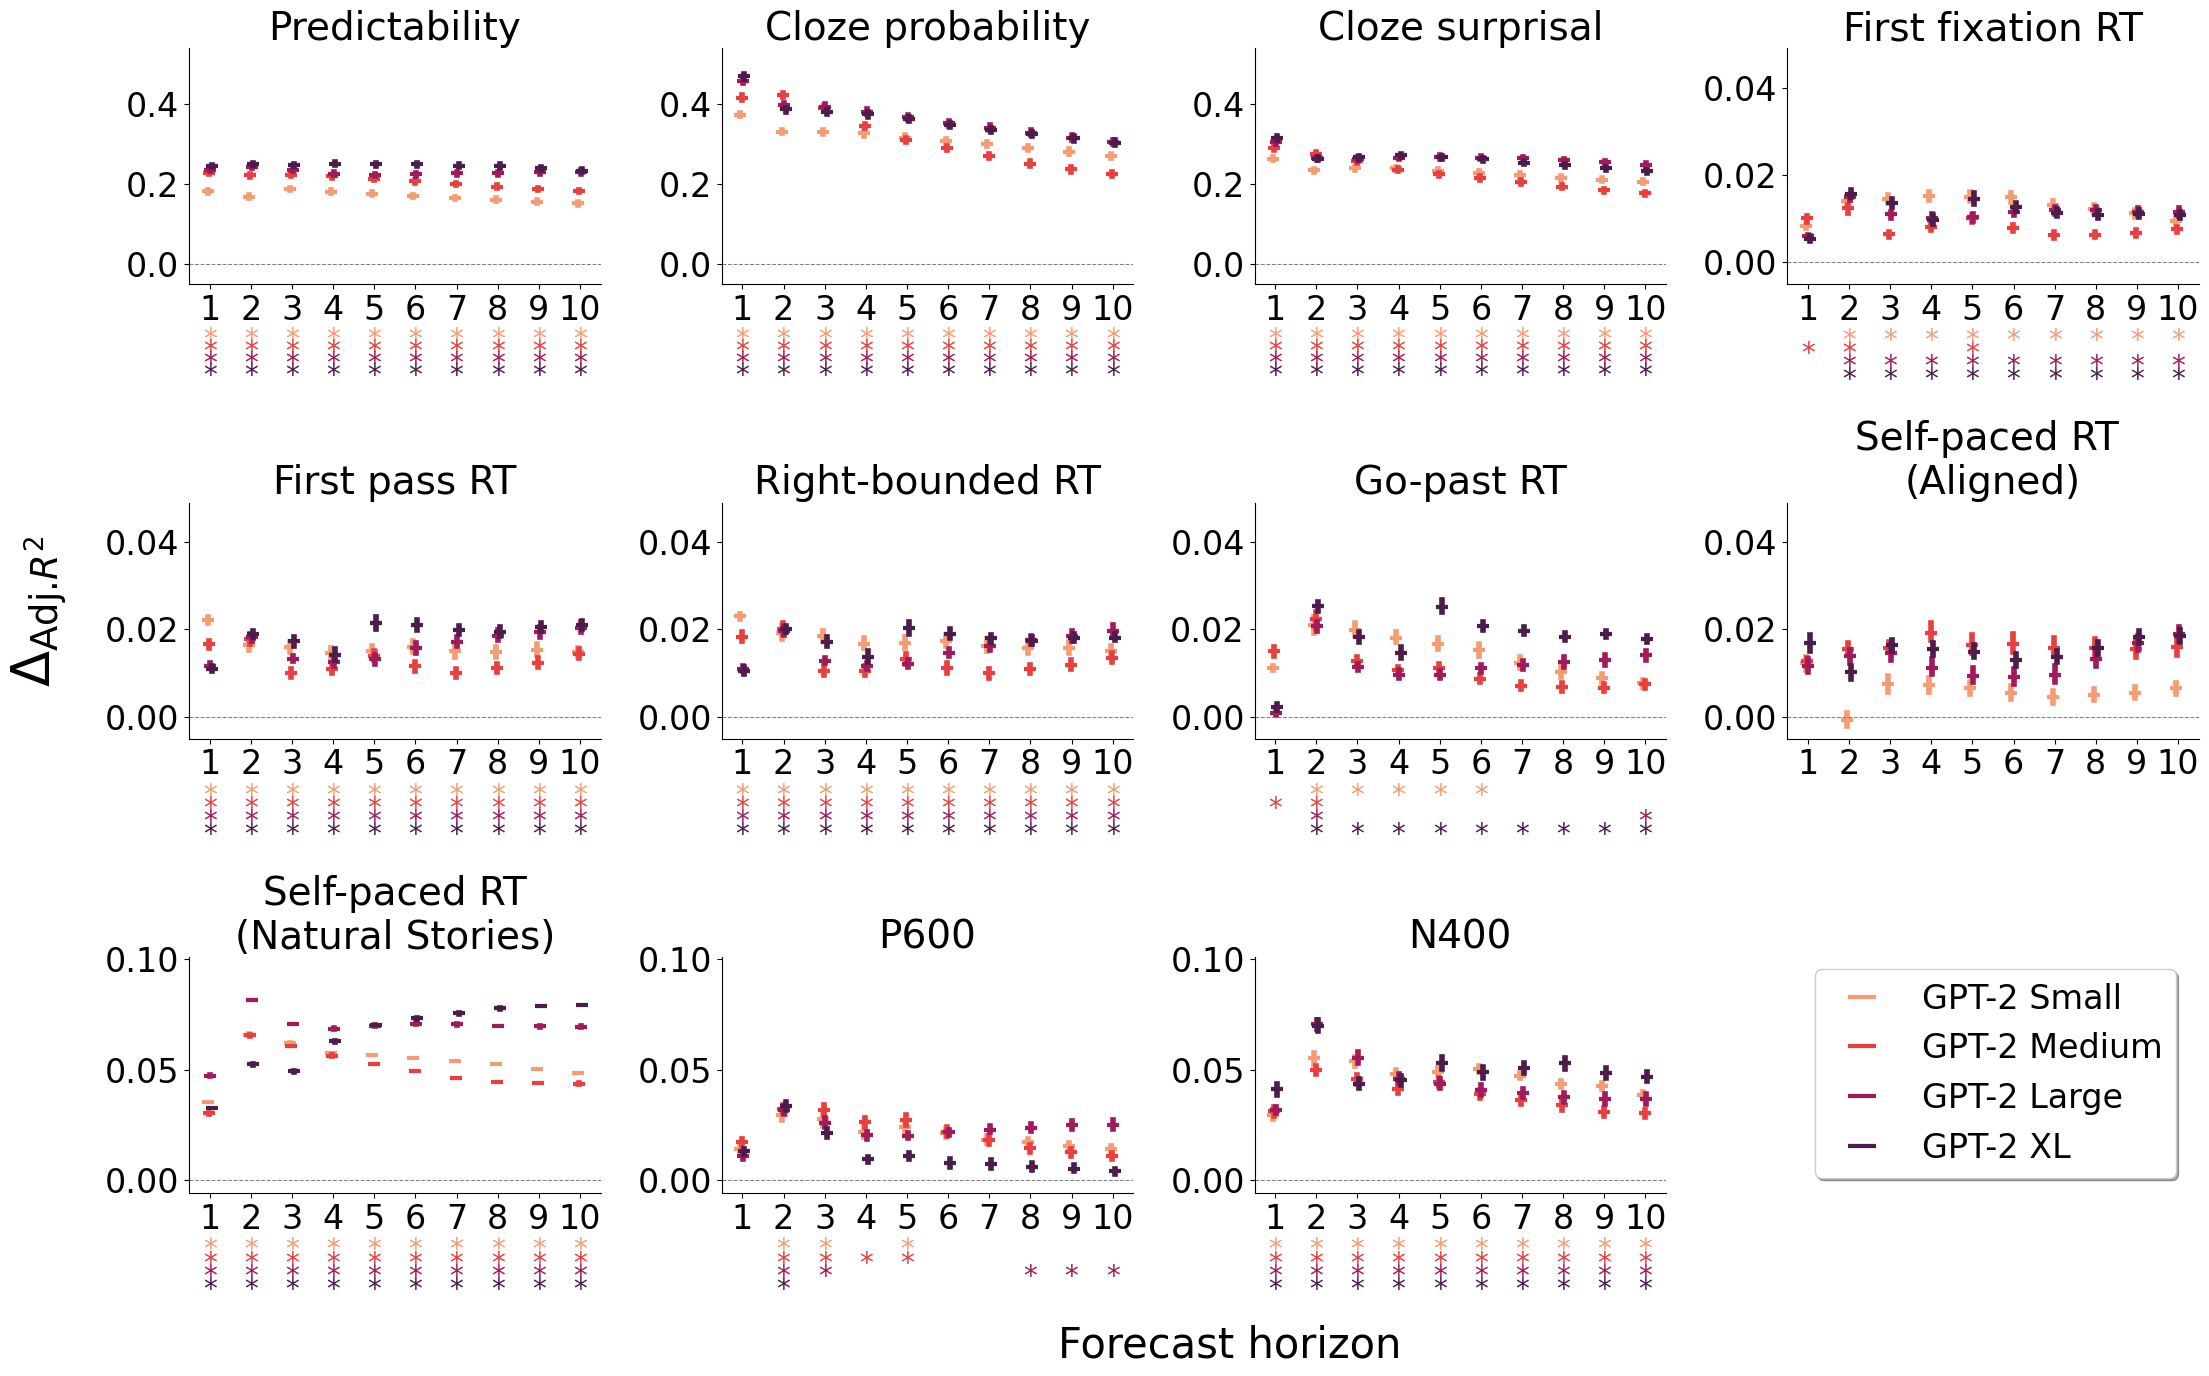

In [80]:
LAYERS = {
    "GPT-2 Small": list(range(0, 13)),
    "GPT-2 Medium": list(range(0, 25, 2)),
    "GPT-2 Large": list(range(0, 37, 3)),
    "GPT-2 XL": list(range(0, 49, 4))
}

matplotlib.rcParams.update({'font.size': 20})
_palette = sns.color_palette("rocket_r", 4)

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT', 
    'P600', 'N400'
]

df = horizon_predictors_all[
    # (~ horizon_predictors_all.y.isin(['sdItemRT', 'entropy', 'rating_sd'])) &
    (horizon_predictors_all.y.isin(target_measurements)) &
    (horizon_predictors_all.baseline == 'Control')
]

plt.figure(figsize=(16, 12))

g = sns.FacetGrid(df, col='y', col_wrap=4, height=4.5, sharey=False, sharex=False, col_order=target_measurements)

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon != 'All') &
        (data.layer == 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='horizon', y='delta_rsquared_adj', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
        plt.ylim(-0.05, 0.54)
    elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
        plt.ylim(-0.005, 0.049)
    elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
        plt.ylim(-0.005, 0.031)
    elif col in [ 'meanItemRT', 'P600', 'N400']:
        plt.ylim(-0.006, 0.101)
        
    plt.xticks(rotation=0, ha='center', fontsize=24)
    plt.yticks(rotation=0, fontsize=24)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, horizon in enumerate(data_folds.horizon.unique()):
            significant = data[
                (data.fold == 'full') &
                (data.horizon == horizon) &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.layer == "All")
            ].significant.values[0]

            significance_label = '*' if significant else '' 
            
            if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
                plt.text(j, -0.19 - i * 0.03, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
                plt.text(j, -0.018 - i * 0.003, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
                plt.text(j, -0.009 - i * 0.002, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            elif col in [ 'meanItemRT', 'P600', 'N400']:
                plt.text(j, -0.032 - i * 0.006, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.98, 0.19), fontsize=24, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)
    
g.fig.text(0.455, -0.02, s='Forecast horizon',fontdict={'fontsize':30})
g.fig.text(-0.03, 0.49, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/revision2/horizon_predictors_against_control_baseline.pdf', bbox_inches='tight')

# Show plot
plt.show()


In [ ]:
LAYERS = {
    "GPT-2 Small": list(range(0, 13)),
    "GPT-2 Medium": list(range(0, 25, 2)),
    "GPT-2 Large": list(range(0, 37, 3)),
    "GPT-2 XL": list(range(0, 49, 4))
}

matplotlib.rcParams.update({'font.size': 20})
_palette = sns.color_palette("rocket_r", 4)

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT', 
    'P600', 'N400'
]

df = horizon_predictors_all[
    # (~ horizon_predictors_all.y.isin(['sdItemRT', 'entropy', 'rating_sd'])) &
    (horizon_predictors_all.y.isin(target_measurements)) &
    (horizon_predictors_all.baseline == 'Control')
]

plt.figure(figsize=(16, 12))

g = sns.FacetGrid(df, col='y', col_wrap=4, height=4.5, sharey=False, sharex=False, col_order=target_measurements)

def plot_subplot(data, **kwargs):
    data_folds = data[
        (data.fold != 'full') &
        (data.horizon != 'All') &
        (data.layer == 'All') & 
        (data.aggregation == 'mean')
    ]
    
    sns.pointplot(
        x='horizon', y='delta_loglik', hue='model', data=data_folds,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )
    col = data.y.unique()[0]
    # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
    #     plt.ylim(-0.05, 0.54)
    # elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
    #     plt.ylim(-0.005, 0.049)
    # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
    #     plt.ylim(-0.005, 0.031)
    # elif col in [ 'meanItemRT', 'P600', 'N400']:
    #     plt.ylim(-0.006, 0.101)
        
    plt.xticks(rotation=0, ha='center', fontsize=24)
    plt.yticks(rotation=0, fontsize=24)

    # add dashed thin horizontal line at 0
    plt.axhline(0, ls='--', color='gray', lw=0.75)
    
    # Annotated significance
    for i, model in enumerate(data_folds.model.unique()):
        for j, horizon in enumerate(data_folds.horizon.unique()):
            significant = data[
                (data.fold == 'full') &
                (data.horizon == horizon) &
                (data.aggregation == 'mean') &
                (data.model == model) &
                (data.layer == "All")
            ].significant.values[0]

            significance_label = '*' if significant else '' 
            
            # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']:
            #     plt.text(j, -0.19 - i * 0.03, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            # elif col in ['RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time']:
            #     plt.text(j, -0.018 - i * 0.003, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
            #     plt.text(j, -0.009 - i * 0.002, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            # elif col in [ 'meanItemRT', 'P600', 'N400']:
            #     plt.text(j, -0.032 - i * 0.006, significance_label, ha='center', va='center', color=_palette[i], fontsize=20)
            
# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.98, 0.19), fontsize=24, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)
    
g.fig.text(0.455, -0.02, s='Forecast horizon',fontdict={'fontsize':30})
g.fig.text(-0.03, 0.49, s='$\Delta_{\\mathcal{L}}$',fontdict={'fontsize':38}, rotation=90)

# Save plot
plt.tight_layout()
plt.savefig('figures/revision2/horizon_predictors_against_control_baseline_loglik.pdf', bbox_inches='tight')

# Show plot
plt.show()


### Partial correlation surprisal - incremental information value

In [3]:
estimates_natst = pd.read_csv("preprocessed_corpora/naturalstories_preprocessed_normalised.csv")
estimates_natst = estimates_natst[estimates_natst.columns.drop(list(estimates_natst.filter(regex='_Deuclidean')))]
estimates_natst = estimates_natst[estimates_natst.columns.drop(list(estimates_natst.filter(regex='_Dcosine_S')))]
estimates_natst = estimates_natst.rename(columns={'zone': 'context_length'})

estimates_devarda = pd.read_csv("preprocessed_corpora/aligned_preprocessed_normalised.csv")

estimates = pd.concat([estimates_devarda, estimates_natst])


In [49]:
MODEL_NAMES = ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
FORECAST_HORIZONS = list(range(1, 11))
_LAYERS = {
    "gpt2-small": list(range(0, 13)),
    "gpt2-medium": list(range(0, 25, 2)),
    "gpt2-large": list(range(0, 37, 3)),
    "gpt2-xl": list(range(0, 49, 4))
}
model_name_labels = {
    "gpt2-small": "GPT-2 Small",
    "gpt2-medium": "GPT-2 Medium",
    "gpt2-large": "GPT-2 Large",
    "gpt2-xl": "GPT-2 XL"
}
distance_metric = "cosine_std"

matrices_mean = {}
matrices_min = {}
matrices_max = {}

for model in MODEL_NAMES:
    matrices_mean[model] = np.zeros((len(_LAYERS[model]), len(FORECAST_HORIZONS)))
    matrices_min[model] = np.zeros((len(_LAYERS[model]), len(FORECAST_HORIZONS)))
    matrices_max[model] = np.zeros((len(_LAYERS[model]), len(FORECAST_HORIZONS)))
                                   
    for j, layer in enumerate(_LAYERS[model][::-1]):
        for k, horizon in enumerate(FORECAST_HORIZONS):
                                           
            col_mean = f'{model}_ias_H{horizon}_L{layer}_D{distance_metric}_Smean'
            col_min = f'{model}_ias_H{horizon}_L{layer}_D{distance_metric}_Smin'
            col_max = f'{model}_ias_H{horizon}_L{layer}_D{distance_metric}_Smax'
            
            matrices_mean[model][j, k] = pg.partial_corr(
                data=estimates, 
                x=f'{model}_surprisal', 
                y=col_mean, 
                covar=['length', 'context_length', 'Subtlex_log10']
            ).round(3)['r']
            
            matrices_min[model][j, k] = pg.partial_corr(
                data=estimates, 
                x=f'{model}_surprisal', 
                y=col_min, 
                covar=['length', 'context_length', 'Subtlex_log10']
            ).round(3)['r']

            matrices_max[model][j, k] = pg.partial_corr(
                data=estimates, 
                x=f'{model}_surprisal', 
                y=col_max, 
                covar=['length', 'context_length', 'Subtlex_log10']
            ).round(3)['r']
            

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/4202868034.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrices_mean[model][j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/4202868034.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrices_min[model][j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/4202868034.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  matrices_max[model][j, k] = pg.partial_corr(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/4202868034.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError 

/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/3420227308.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


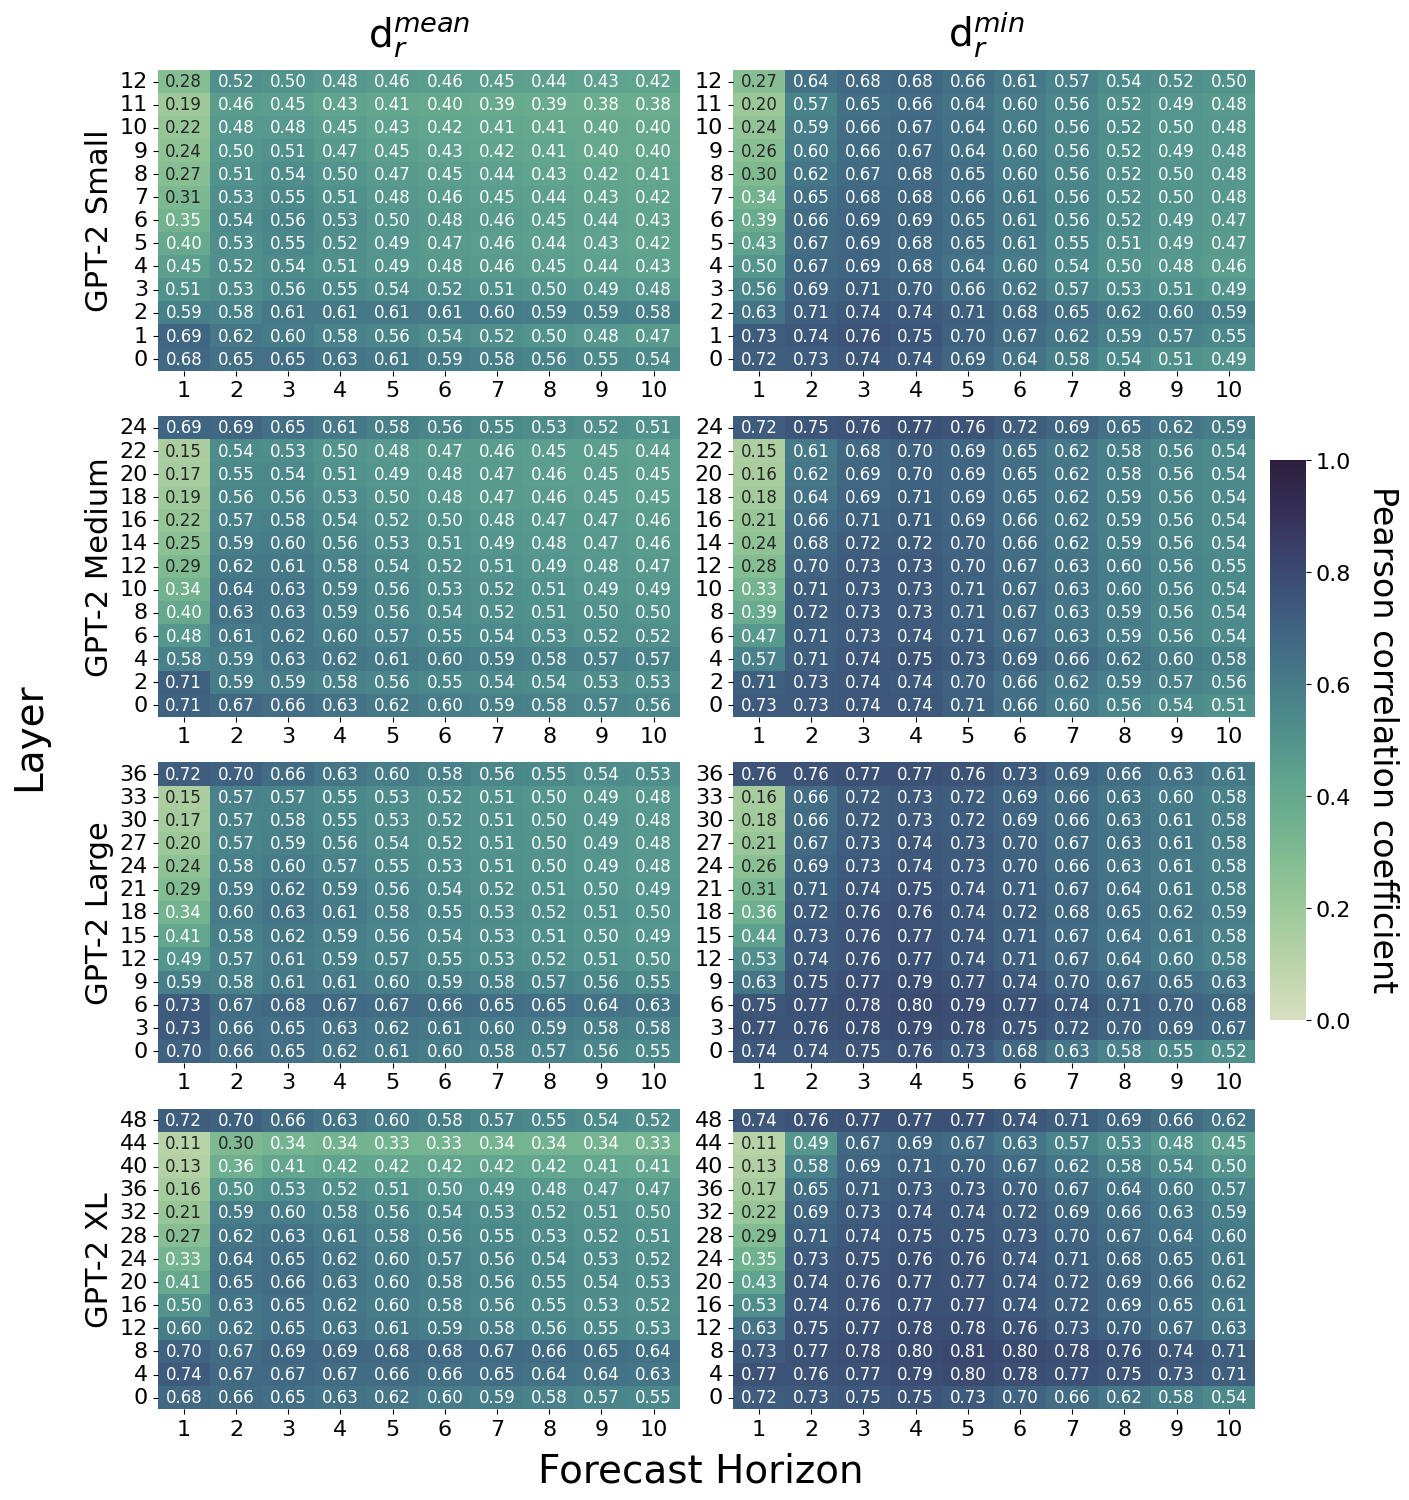

In [42]:
fig, ax = plt.subplots(4, 2, figsize=(12, 14))
cbar_ax = fig.add_axes([1, .31, .03, .4])

for i, model in enumerate(MODEL_NAMES):
    sns.heatmap(
        matrices_mean[model],
        annot=True, 
        ax=ax[i, 0],
        cbar=i==0,
        cbar_ax=None if i else cbar_ax,
        cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
        vmin=0, vmax=1,
        fmt=".2f",
        annot_kws={"fontsize":12}
    )
    
    ax[i, 0].set_ylabel(model_name_labels[model], fontsize=22)
    ax[i, 0].set_yticklabels(_LAYERS[model][::-1], rotation=0, fontsize=16)
    ax[i, 0].set_xticklabels(FORECAST_HORIZONS, fontsize=16)

    # increase font of colorbar
    if i == 0:
        cbar = ax[i, 0].collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

    sns.heatmap(
        matrices_min[model],
        annot=True, 
        ax=ax[i, 1], 
        cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
        vmin=0, vmax=1,
        cbar=False,
        fmt=".2f",
        annot_kws={"fontsize":12}
    )
    
    ax[i, 1].set_yticklabels(_LAYERS[model][::-1], rotation=0, fontsize=16)
    ax[i, 1].set_xticklabels(FORECAST_HORIZONS, fontsize=16)
    
fig.text(0.39, -0.02, s='Forecast Horizon',fontdict={'fontsize':28})
fig.text(-0.05, 0.48, s='Layer',fontdict={'fontsize':28}, rotation=90)
fig.text(0.248, 1.005, s='$\\mathrm{d}_{r}^{mean}$',fontdict={'fontsize':28, 'weight':'bold'}, rotation=0)
fig.text(0.732, 1.005, s='$\\mathrm{d}_{r}^{min}$',fontdict={'fontsize':28, 'weight':'bold'}, rotation=0)
fig.text(1.08, 0.335, s='Pearson correlation coefficient',fontdict={'fontsize':24}, rotation=270)


# plt.subplots_adjust(
#     wspace = 0.3,
#     hspace = 0.3
# )
plt.tight_layout()

# plt.suptitle('Partial Correlation between Surprisal and Information Value (Mean)', fontsize=6
plt.savefig(f'figures/revision2/partial_corr_ias_{distance_metric}_mean_min.pdf', bbox_inches='tight')

plt.show()


/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_66969/39151100.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


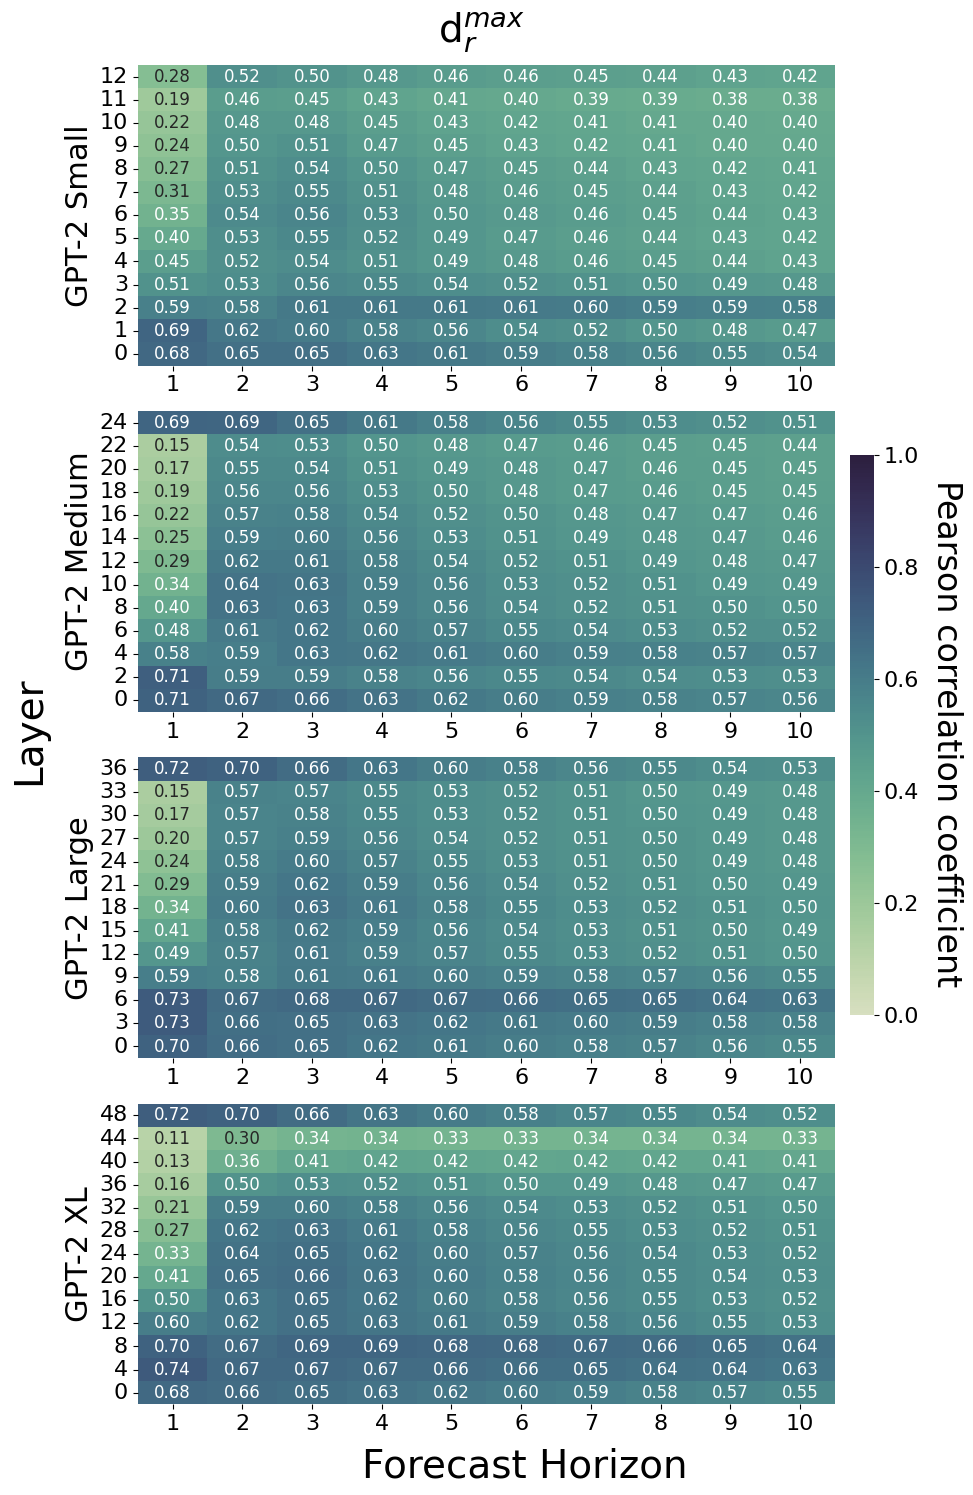

In [58]:
fig, ax = plt.subplots(4, 1, figsize=(8, 14))
cbar_ax = fig.add_axes([1, .31, .03, .4])

for i, model in enumerate(MODEL_NAMES):
    sns.heatmap(
        matrices_mean[model],
        annot=True, 
        ax=ax[i],
        cbar=i==0,
        cbar_ax=None if i else cbar_ax,
        cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
        vmin=0, vmax=1,
        fmt=".2f",
        annot_kws={"fontsize":12}
    )
    
    ax[i].set_ylabel(model_name_labels[model], fontsize=22)
    ax[i].set_yticklabels(_LAYERS[model][::-1], rotation=0, fontsize=16)
    ax[i].set_xticklabels(FORECAST_HORIZONS, fontsize=16)

    # increase font of colorbar
    if i == 0:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)
    
fig.text(0.39, -0.02, s='Forecast Horizon',fontdict={'fontsize':28})
fig.text(-0.05, 0.48, s='Layer',fontdict={'fontsize':28}, rotation=90)
fig.text(0.485, 1.005, s='$\\mathrm{d}_{r}^{max}$',fontdict={'fontsize':28, 'weight':'bold'}, rotation=0)
fig.text(1.1, 0.335, s='Pearson correlation coefficient',fontdict={'fontsize':24}, rotation=270)


# plt.subplots_adjust(
#     wspace = 0.3,
#     hspace = 0.3
# )
plt.tight_layout()

# plt.suptitle('Partial Correlation between Surprisal and Information Value (Mean)', fontsize=6
plt.savefig(f'figures/revision2/partial_corr_ias_{distance_metric}_max.pdf', bbox_inches='tight')

plt.show()


### Full Model

In [12]:
y_labels = {
    'cloze_p_smoothed': 'Cloze probability',
    'cloze_s': 'Cloze surprisal',
    'rating_mean': 'Predictability',
    'RTfirstfix': 'First fixation RT',
    'RTfirstpass': 'First pass RT',
    'RTrightbound': 'Right-bounded RT',
    'RTgopast': 'Go-past RT',
    'self_paced_reading_time': 'Self-paced RT',
    'meanItemRT': 'Self-paced RT\n(Natural Stories)',
    'ELAN': 'ELAN',
    'LAN': 'LAN',
    'PNP': 'PNP',
    'EPNP': 'EPNP',
    'P600': 'P600',
    'N400': 'N400',
}

rename_model_dict = {
    'gpt2_small': 'GPT-2 Small',
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2_xl': 'GPT-2 XL',
    # 'No Model': 'No Model'
}

In [20]:
# Load the dataframes
full_comparison_aligned = pd.read_csv("results_final/ols_aligned_ias_cosine_std_comparison_all.csv")
full_comparison_ns = pd.read_csv("results_final/ols_ns_ias_cosine_std_comparison_all.csv")


# Merge the dataframes
full_comparison_aligned["corpus"] = "Aligned"
full_comparison_ns["corpus"] = "Natural Stories"


# Perform the Holm-Bonferroni correction
alpha = 0.05

full_comparison_aligned['significant_ias_vs_surprisal'] = False
retained_indices_aligned = holm_bonferroni(full_comparison_aligned, 'anova_p_ias_vs_surprisal', alpha)
full_comparison_aligned.loc[retained_indices_aligned, 'significant_ias_vs_surprisal'] = True

full_comparison_ns['significant_ias_vs_surprisal'] = False
retained_indices_ns = holm_bonferroni(full_comparison_ns, 'anova_p_ias_vs_surprisal', alpha)
full_comparison_ns.loc[retained_indices_ns, 'significant_ias_vs_surprisal'] = True

full_comparison_aligned['significant_surprisal_vs_ias'] = False
retained_indices_aligned = holm_bonferroni(full_comparison_aligned, 'anova_p_surprisal_vs_ias', alpha)
full_comparison_aligned.loc[retained_indices_aligned, 'significant_surprisal_vs_ias'] = True

full_comparison_ns['significant_surprisal_vs_ias'] = False
retained_indices_ns = holm_bonferroni(full_comparison_ns, 'anova_p_surprisal_vs_ias', alpha)
full_comparison_ns.loc[retained_indices_ns, 'significant_surprisal_vs_ias'] = True

full_comparison_aligned['significant_both_vs_surprisal'] = False
retained_indices_aligned = holm_bonferroni(full_comparison_aligned, 'anova_p_both_vs_surprisal', alpha)
full_comparison_aligned.loc[retained_indices_aligned, 'significant_both_vs_surprisal'] = True

full_comparison_ns['significant_both_vs_surprisal'] = False
retained_indices_ns = holm_bonferroni(full_comparison_ns, 'anova_p_both_vs_surprisal', alpha)
full_comparison_ns.loc[retained_indices_ns, 'significant_both_vs_surprisal'] = True

full_comparison_aligned['significant_both_vs_ias'] = False
retained_indices_aligned = holm_bonferroni(full_comparison_aligned, 'anova_p_both_vs_ias', alpha)
full_comparison_aligned.loc[retained_indices_aligned, 'significant_both_vs_ias'] = True

full_comparison_ns['significant_both_vs_ias'] = False
retained_indices_ns = holm_bonferroni(full_comparison_ns, 'anova_p_both_vs_ias', alpha)
full_comparison_ns.loc[retained_indices_ns, 'significant_both_vs_ias'] = True


full_comparison_df = pd.concat([full_comparison_aligned, full_comparison_ns])

full_comparison_df = full_comparison_df[~full_comparison_df.metric.str.contains('min')]
full_comparison_df = full_comparison_df[~full_comparison_df.metric.str.contains('Baseline')]

# full_comparison_df['metric'] = full_comparison_df['metric'].replace('Control', 'Baseline')
full_comparison_df['metric'] = full_comparison_df['metric'].replace('IAS (mean)', 'IAS')
full_comparison_df['metric'] = full_comparison_df['metric'].replace('Surprisal + IAS (mean)', 'Surprisal + IAS')


# replace all nan values in the model column with 'No Model'
# full_comparison_df['model'] = full_comparison_df['model'].fillna('No Model')
full_comparison_df['model'] = full_comparison_df['model'].map(rename_model_dict)

# order model column by the order of the model names
full_comparison_df['model'] = pd.Categorical(full_comparison_df['model'], categories=rename_model_dict.values(), ordered=True)



<>:66: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\D'
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_17448/251289215.py:66: SyntaxWarning: invalid escape sequence '\D'
  g.fig.text(-0.035, 0.525, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_17448/251289215.py:21: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_17448/251289215.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/br/3tw2dd_x2xd230m_jy9q2zxc0000gn/T/ipykernel_17448/251289215.py:21: UserWarning: The palette list has more values (5) than needed (4), which may not be int

<Figure size 1600x1200 with 0 Axes>

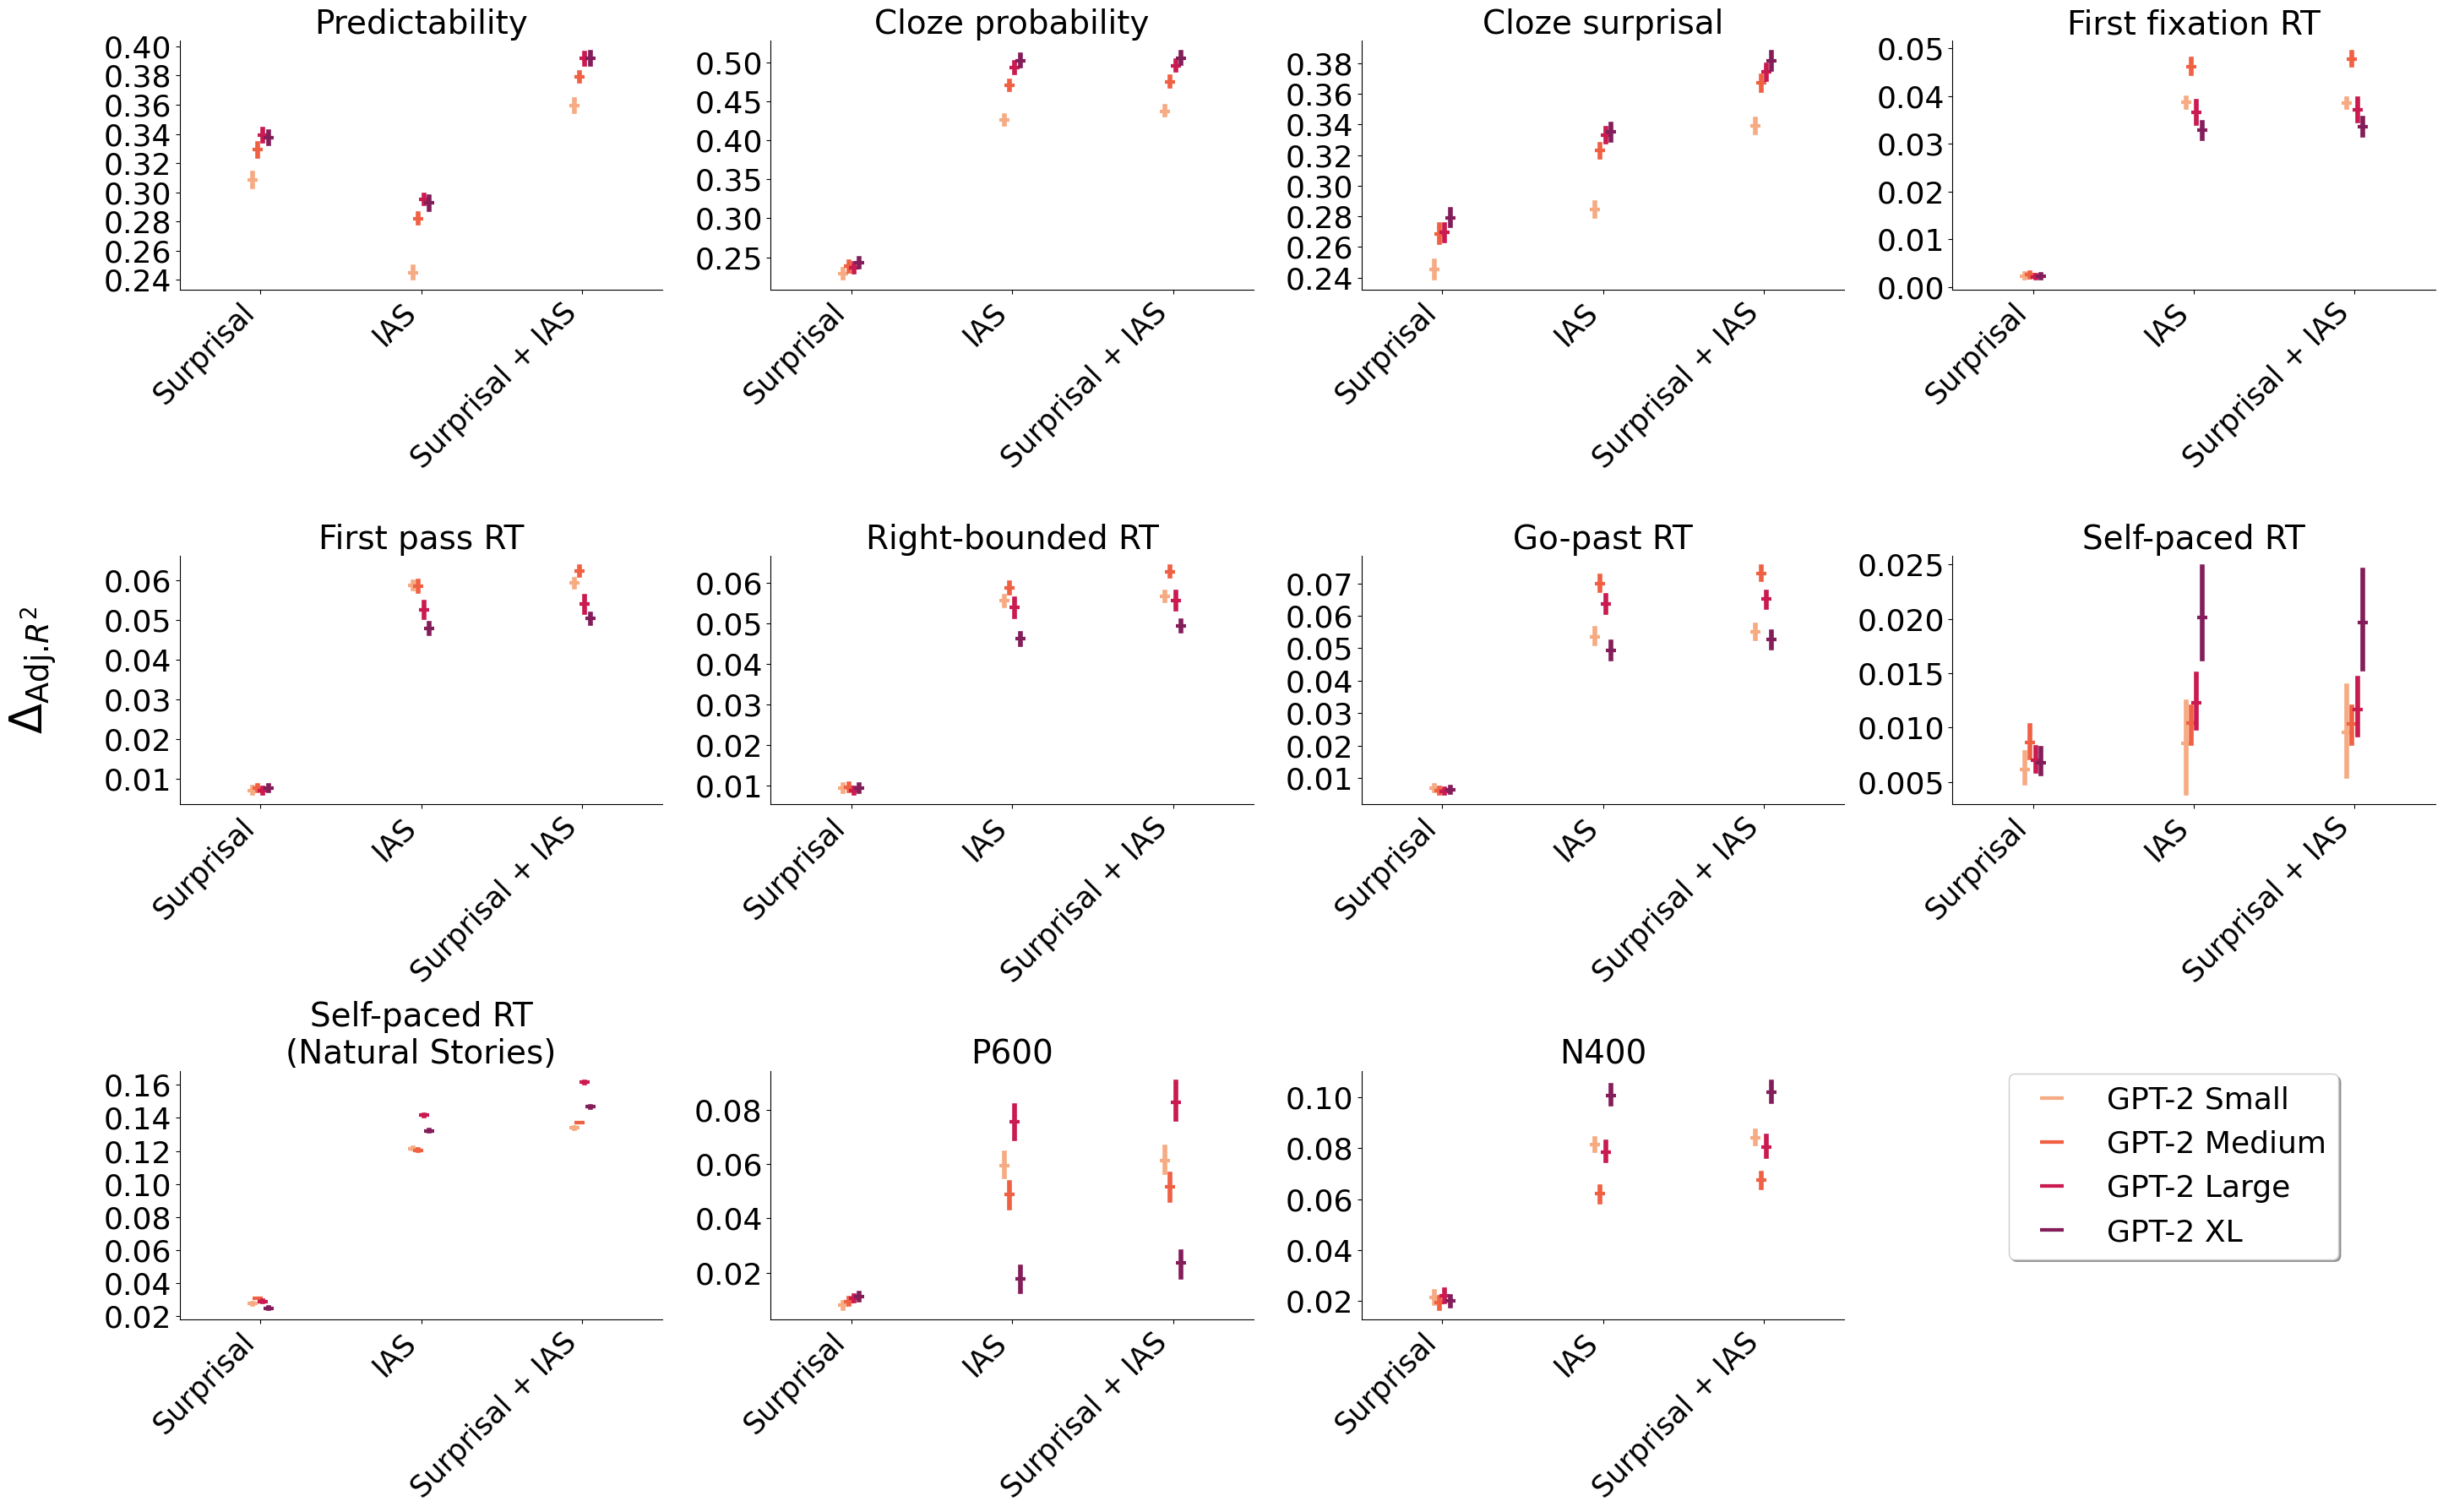

In [18]:
# Plot, for each y, the delta R^2 of the full model against the baseline and IAS

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT',
     'P600', 'N400' #'ELAN', 'LAN', 'PNP', 'EPNP',
]

plt.figure(figsize=(16, 12))
_palette = sns.color_palette("rocket_r", 5)

g = sns.FacetGrid(
    full_comparison_df[
        (full_comparison_df.y.isin(target_measurements)) &
        (full_comparison_df.fold != 'full')
    ],
    col='y', col_wrap=4, height=6, sharey=False, sharex=False, col_order=target_measurements, row_order=['Surprisal', 'Full IAS', 'Surprisal + Full IAS']
)

def plot_subplot(data, **kwargs):
    sns.pointplot(
        x='metric', y='delta_rsquared_adj', hue='model', data=data,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )

    # col = data.y.unique()[0]
    # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']: #, 
    #     plt.ylim(0.17, 0.8)
    # elif col in ['RTfirstfix']:
    #     plt.ylim(0.6, 0.7)
    # elif col in ['RTfirstpass', 'RTrightbound']: 
    #     plt.ylim(0.57, 0.7)
    # elif col in ['RTgopast']:
    #     plt.ylim(0.38, 0.52)
    # elif col in ['self_paced_reading_time']:
    #     plt.ylim(0.028, 0.06)
    # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
    #     plt.ylim(-0.005, 0.031)
    # elif col in [ 'P600', 'N400']:
    #     plt.ylim(0.025, 0.2)
    # elif col in ['meanItemRT']:
    #     plt.ylim(0.17, 0.4)
    #     pass


    plt.yticks(fontsize=26)        
    plt.xticks(rotation=45, ha='right', fontsize=25)


# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.96, 0.23), fontsize=26, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)

# g.fig.text(0.455, -0.02, s='Regressor',fontdict={'fontsize':24})
g.fig.text(-0.035, 0.525, s='$\Delta_{\\text{Adj.} R^2}$',fontdict={'fontsize':38}, rotation=90)

# Save plot

plt.tight_layout()
# plt.savefig('figures/revision2/full_comparison_deltaadjrsq.pdf', bbox_inches='tight')

# Show plot
plt.show()


In [40]:
full_comparison_df[
    (full_comparison_df.fold == 'full') &
    (full_comparison_df.y == 'N400')
][
    ['y', 'metric', 'model', 'significant_ias_vs_surprisal', 'significant_both_vs_surprisal', 'significant_both_vs_ias']
]

y           metric         model  significant_ias_vs_surprisal  \
253  N400        Surprisal   GPT-2 Small                         False   
254  N400              IAS   GPT-2 Small                          True   
255  N400  Surprisal + IAS   GPT-2 Small                         False   
258  N400        Surprisal  GPT-2 Medium                         False   
259  N400              IAS  GPT-2 Medium                         False   
260  N400  Surprisal + IAS  GPT-2 Medium                         False   
263  N400        Surprisal   GPT-2 Large                         False   
264  N400              IAS   GPT-2 Large                          True   
265  N400  Surprisal + IAS   GPT-2 Large                         False   
268  N400        Surprisal      GPT-2 XL                         False   
269  N400              IAS      GPT-2 XL                          True   
270  N400  Surprisal + IAS      GPT-2 XL                         False   

     significant_both_vs_surprisal  significant_both_vs_ias  
253                          False                    False  
254                          False                    False  
255                           True                    False  
258                          False                    False  
259                          False                    False  
260                          False                    False  
263                          False                    False  
264                          False                    False  
265                           True                    False  
268                          False                    False  
269                          False                    False  
270                           True                    False

In [ ]:
# Plot, for each y, the delta R^2 of the full model against the baseline and IAS

target_measurements = [
    'rating_mean', 'cloze_p_smoothed', 'cloze_s', 
    'RTfirstfix', 'RTfirstpass', 'RTrightbound', 'RTgopast', 'self_paced_reading_time', 'meanItemRT',
     'P600', 'N400' #'ELAN', 'LAN', 'PNP', 'EPNP',
]

plt.figure(figsize=(16, 12))
_palette = sns.color_palette("rocket_r", 5)

g = sns.FacetGrid(
    full_comparison_df[
        (full_comparison_df.y.isin(target_measurements)) &
        (full_comparison_df.fold != 'full')
    ],
    col='y', col_wrap=4, height=6, sharey=False, sharex=False, col_order=target_measurements, row_order=['Surprisal', 'Full IAS', 'Surprisal + Full IAS']
)

def plot_subplot(data, **kwargs):
    sns.pointplot(
        x='metric', y='delta_loglik', hue='model', data=data,
        dodge=True, ax=plt.gca(), errorbar=("ci", 95), 
        palette=_palette, 
        linestyles='', 
        markers='_', scale=1.5,
        **kwargs
    )

    # col = data.y.unique()[0]
    # if col in ['cloze_p_smoothed', 'cloze_s', 'rating_mean']: #, 
    #     plt.ylim(0.17, 0.8)
    # elif col in ['RTfirstfix']:
    #     plt.ylim(0.6, 0.7)
    # elif col in ['RTfirstpass', 'RTrightbound']: 
    #     plt.ylim(0.57, 0.7)
    # elif col in ['RTgopast']:
    #     plt.ylim(0.38, 0.52)
    # elif col in ['self_paced_reading_time']:
    #     plt.ylim(0.028, 0.06)
    # elif col in ['ELAN', 'LAN', 'EPNP', 'PNP']:
    #     plt.ylim(-0.005, 0.031)
    # elif col in [ 'P600', 'N400']:
    #     plt.ylim(0.025, 0.2)
    # elif col in ['meanItemRT']:
    #     plt.ylim(0.17, 0.4)
    #     pass


    plt.yticks(fontsize=26)        
    plt.xticks(rotation=45, ha='right', fontsize=25)


# Map the function to each subplot
g.map_dataframe(plot_subplot)

# Adjust labels and legend
g.set_axis_labels('', '')
g.add_legend(title='', bbox_to_anchor=(0.96, 0.23), fontsize=26, markerscale=2.5, ncol=1, frameon=True, fancybox=True, shadow=True)


for ax, y in zip(g.axes.flat, target_measurements):
    ax.set_title(y_labels[y], fontsize=28)

# g.fig.text(0.455, -0.02, s='Regressor',fontdict={'fontsize':24})
g.fig.text(-0.035, 0.525, s='$\\mathcal{L}$',fontdict={'fontsize':38}, rotation=90)

# Save plot

plt.tight_layout()
plt.savefig('figures/revision2/full_comparison_deltaloglik.pdf', bbox_inches='tight')

# Show plot
plt.show()
